# LLMS

Nous comparons les résultats donnés par les modèles llama2 et llama2:13b, avec le même prompt

In [14]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import Levenshtein
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

In [15]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
#from langchain_community.llms import Ollama
# from langchain.callbacks.manager import CallbackManager

In [3]:
import torch
print(torch.cuda.is_available())

True


In [4]:
import tensorflow as tf

# Vérifier la présence de GPU
if tf.test.gpu_device_name():
    print('GPU détecté')
else:
    print("Aucun GPU détecté")

2024-04-29 18:08:47.622320: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 18:08:47.650222: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 18:08:48.098452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU détecté


2024-04-29 18:08:48.412175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 18:08:48.413071: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 18:08:48.413164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Espace fonctions

In [5]:
def count_word_text(text):
    count = len(text.split())
    return count

def clean_text(text):
    text = text.lower()
    # Supprimer les retours à la ligne
    text = text.replace('\n', ' ')
    # Supprimer la numérotation au début du texte s'il existe
    text = re.sub(r'^\d+\.\s', '', text)
    return text

def levenshtein_similarity(generated, real):
    distance = Levenshtein.distance(generated.lower(), real.lower())
    max_length = max(len(generated), len(real))
    levenshtein_sim = 1 - (distance / max_length)
    return levenshtein_sim
def cosinus_similarity(generated, real):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([generated, real])
    cosine_sim = cosine_similarity(vectors[0], vectors[1])[0][0]
    return cosine_sim

def bleu_similarity(generated, real):
    # Calcule le score BLEU pour une paire de titres générés et réels
    return corpus_bleu([[real.split()]], [generated.split()], weights=(1, 0, 0, 0))

def rouge_similarity(generated, real):
    # Initialise l'objet scorer ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    # Calcule les scores ROUGE
    scores = scorer.score(generated, real)
    rouge1_score = scores['rouge1'].fmeasure
    rougeL_score = scores['rougeL'].fmeasure
    return rouge1_score, rougeL_score

def get_performances(generated_titles, real_titles):
    # Initialiser les listes pour stocker les scores
    levenshtein_scores = []
    cosine_scores = []
    bleu_scores = []
    rouge1_scores = []
    rougeL_scores = []

    # Calculer les scores pour chaque paire de titres générés et réels
    for generated, real in zip(generated_titles, real_titles):
        levenshtein_scores.append(levenshtein_similarity(generated, real))
        cosine_scores.append(cosinus_similarity(generated, real))
        bleu_scores.append(bleu_similarity(generated, real))
        rouge1_score, rougeL_score = rouge_similarity(generated, real)
        rouge1_scores.append(rouge1_score)
        rougeL_scores.append(rougeL_score)

    # Calculer les moyennes des scores
    mean_levenshtein = sum(levenshtein_scores) / len(levenshtein_scores)
    mean_cosine = sum(cosine_scores) / len(cosine_scores)
    mean_bleu = sum(bleu_scores) / len(bleu_scores)
    mean_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    mean_rougeL = sum(rougeL_scores) / len(rougeL_scores)

    return mean_levenshtein, mean_cosine, mean_bleu, mean_rouge1, mean_rougeL


In [16]:
data = pd.read_csv("selected_df.csv")
data.shape

(923, 9)

In [13]:
data.head(5)

,Title,Text,text_char,Len_text,Len_title,Text_clean,Text_tokens,Text_tokens_clean,Title_clean
0,Hands-on Graph Neural Networks with PyTorch & ...,"In my last article, I introduced the concept o...",829,139,9,"in my last article, i introduced the concept o...","['in', 'my', 'last', 'article', 'i', 'introduc...","['last', 'article', 'introduced', 'concept', '...","['hands', 'graph', 'neural', 'networks', 'pyto..."
1,How to Use ggplot2 in Python,Introduction\n\nThanks to its strict implement...,5656,953,6,introduction thanks to its strict implementat...,"['introduction', 'thanks', 'to', 'its', 'stric...","['introduction', 'thanks', 'strict', 'implemen...","['use', 'ggplot2', 'python']"
2,Databricks: How to Save Data Frames as CSV Fil...,Photo credit to Mika Baumeister from Unsplash\...,1784,280,13,photo credit to mika baumeister from unsplash ...,"['photo', 'credit', 'to', 'mika', 'baumeister'...","['photo', 'credit', 'mika', 'baumeister', 'uns...","['databricks', 'save', 'data', 'frames', 'csv'..."
3,A Step-by-Step Implementation of Gradient Desc...,A Step-by-Step Implementation of Gradient Desc...,4797,737,8,a step-by-step implementation of gradient desc...,"['a', 'step', 'by', 'step', 'implementation', ...","['step', 'step', 'implementation', 'gradient',...","['step', 'step', 'implementation', 'gradient',..."
4,An Easy Introduction to SQL for Data Scientists,Want to be inspired? Come join my Super Quotes...,1830,309,8,want to be inspired? come join my super quotes...,"['want', 'to', 'be', 'inspired', 'come', 'join...","['want', 'inspired', 'come', 'join', 'super', ...","['easy', 'introduction', 'sql', 'data', 'scien..."


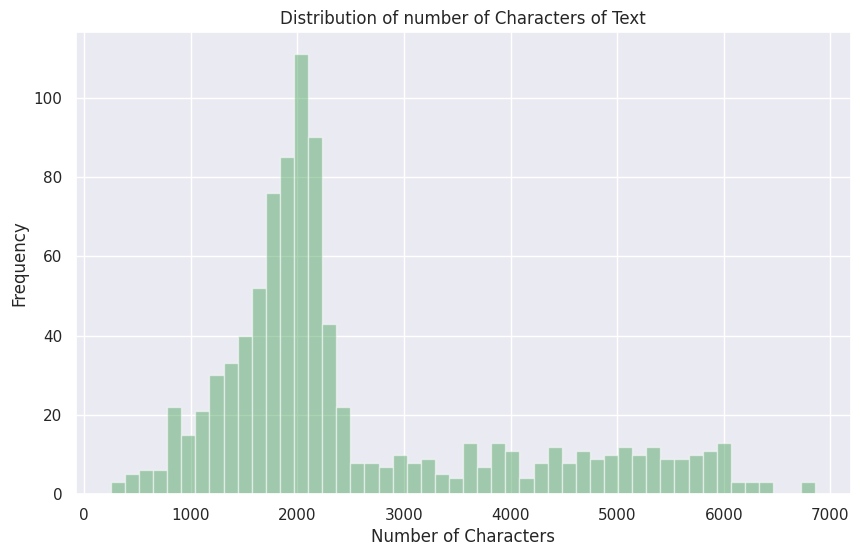

In [30]:
plt.figure(figsize=(10,6))
plt.hist(data['text_char'], bins=50, alpha=0.5, color='g')
plt.title('Distribution of number of Characters of Text')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

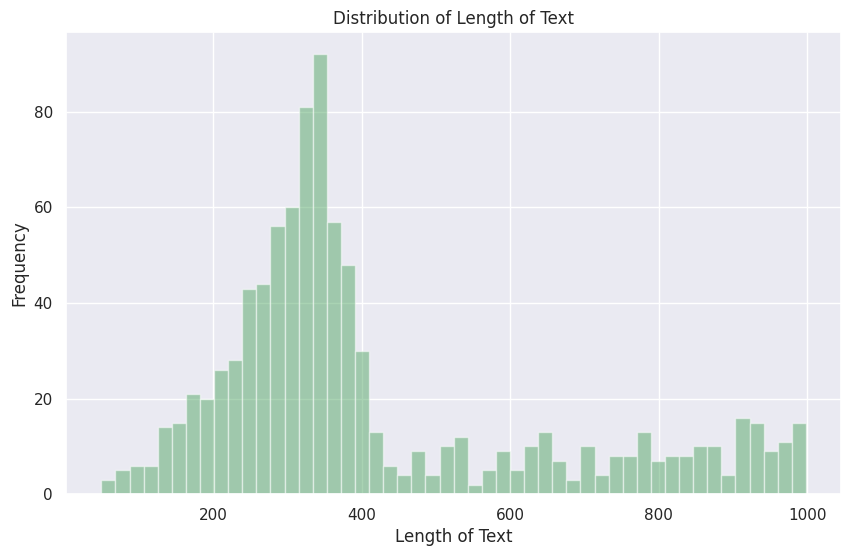

In [31]:
plt.figure(figsize=(10,6))
plt.hist(data['Len_text'], bins=50, alpha=0.5, color='g')
plt.title('Distribution of Length of Text')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

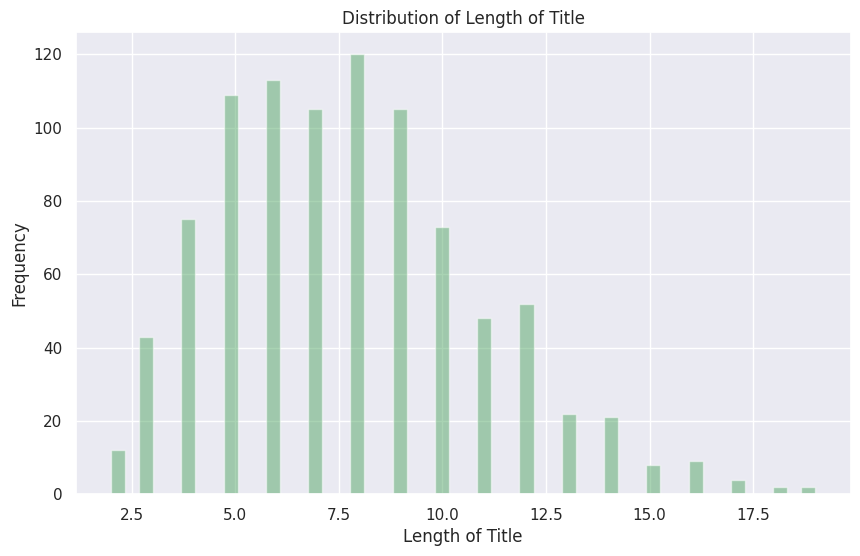

In [32]:
plt.figure(figsize=(10,6))
plt.hist(data['Len_title'], bins=50, alpha=0.5, color='g')
plt.title('Distribution of Length of Title')
plt.xlabel('Length of Title')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## llama2:13b

In [6]:
text = """ In my last article, I introduced the concept of Graph Neural Network (GNN) and some recent advancements of it.\
Since this topic is getting seriously hyped up, I decided to make this tutorial on how to easily implement your Graph Neural Network\
in your project. You will learn how to construct your own GNN with PyTorch Geometric, \
and how to use GNN to solve a real-world problem (Recsys Challenge 2015).
\n\nIn this blog post, we will be using PyTorch and PyTorch Geometric (PyG), a Graph Neural Network framework built on top of PyTorch\
that runs blazingly fast. It is several times faster than the most well-known GNN framework, DGL.\n\nAside from its remarkable speed, \
PyG comes with a collection of well-implemented GNN models illustrated in various papers.\
Therefore, it would be very handy to reproduce the experiments with PyG."""

In [17]:
llm_model = "llama2:13b"

llm = ChatOllama(model=llm_model,
                 temperature=0
                )
prompt = ChatPromptTemplate.from_template("summerize {text}")

chain = prompt | llm | StrOutputParser()

print(chain.invoke({"text": text}))


Here is a summary of the article:

The article provides a tutorial on how to implement a Graph Neural Network (GNN) using PyTorch Geometric (PyG), a fast and powerful GNN framework built on top of PyTorch. The author claims that PyG is several times faster than the most well-known GNN framework, DGL, and comes with a collection of well-implemented GNN models illustrated in various papers. The tutorial will cover how to construct a GNN with PyG and use it to solve a real-world problem (Recsys Challenge 2015). The article is intended for those who want to easily implement GNNs in their projects and reproduce experiments using PyG.


In [36]:
import time

In [39]:
%%time
llm_model = "llama2:13b"

llm = ChatOllama(model=llm_model,
                 temperature=0
                )
prompt = ChatPromptTemplate.from_template("summerize {text}")

chain = prompt | llm | StrOutputParser()

print(chain.invoke({"text": text}))


Here is a summary of the article:

The article provides a tutorial on how to implement a Graph Neural Network (GNN) using PyTorch Geometric (PyG), a fast and powerful GNN framework built on top of PyTorch. The author claims that PyG is several times faster than the most well-known GNN framework, DGL, and comes with a collection of well-implemented GNN models illustrated in various papers. The tutorial will cover how to construct a GNN with PyG and use it to solve a real-world problem (Recsys Challenge 2015). The article is intended for those who want to easily implement GNNs in their projects and reproduce experiments using PyG.
CPU times: user 88.3 ms, sys: 3.92 ms, total: 92.2 ms
Wall time: 50.7 s


In [7]:
%%time
llm_model = "llama2:13b"

llm = ChatOllama(model=llm_model, temperature=0)
prompt = ChatPromptTemplate.from_template("Generate an appropriate title to {text}")

chain = prompt | llm | StrOutputParser()
# llm = llm.to_device("cuda")
print(chain.invoke({"text": text}))


Here are a few potential titles for your blog post:

1. "Building a Graph Neural Network with PyTorch Geometric: A Step-by-Step Tutorial"
2. "Unlocking the Power of Graph Neural Networks with PyTorch Geometric"
3. "Revolutionize Your RecSys Challenge 2015 Solution with PyTorch Geometric GNNs"
4. "PyTorch Geometric: The Fast and Powerful Framework for Graph Neural Networks"
5. "Effortlessly Implement Graph Neural Networks in Your Project with PyTorch Geometric"
6. "From Research to Reality: Leveraging PyTorch Geometric for Real-World GNN Applications"
7. "PyG: The Ultimate Toolkit for Building and Training Graph Neural Networks"
8. "Unleashing the Full Potential of GNNs with PyTorch Geometric's Collection of Well-Implemented Models"
9. "A Comprehensive Guide to Implementing Graph Neural Networks with PyTorch Geometric"
10. "PyTorch Geometric: The Future of Graph Neural Networks is Here"
CPU times: user 81.7 ms, sys: 41 ms, total: 123 ms
Wall time: 32.4 s


In [8]:
%%time
llm_model = "llama2:13b"

llm = ChatOllama(model=llm_model, temperature=0, device="cuda")
prompt = ChatPromptTemplate.from_template("Generate an appropriate title to {text}")

chain = prompt | llm | StrOutputParser()
# llm = llm.to_device("cuda")
print(chain.invoke({"text": text}))


Here are a few potential titles for your blog post:

1. "Building a Graph Neural Network with PyTorch Geometric: A Step-by-Step Tutorial"
2. "Unlocking the Power of Graph Neural Networks with PyTorch Geometric"
3. "Revolutionize Your RecSys Challenge 2015 Solution with PyTorch Geometric GNNs"
4. "PyTorch Geometric: The Fast and Powerful Framework for Graph Neural Networks"
5. "Effortlessly Implement Graph Neural Networks in Your Project with PyTorch Geometric"
6. "From Research to Reality: Leveraging PyTorch Geometric for Real-World GNN Applications"
7. "PyG: The Ultimate Toolkit for Building and Training Graph Neural Networks"
8. "Unleashing the Full Potential of GNNs with PyTorch Geometric's Collection of Well-Implemented Models"
9. "A Beginner's Guide to Building a Graph Neural Network with PyTorch Geometric"
10. "PyTorch Geometric: The Future of Graph Neural Networks is Here"
CPU times: user 75.4 ms, sys: 34 ms, total: 109 ms
Wall time: 27.6 s


In [18]:
llm_model = "llama2:13b"
def get_title(text, llm_model):
    llm = ChatOllama(model=llm_model,
                     temperature=0
                    )
    prompt = ChatPromptTemplate.from_template("Generate an appropriate title to {text}")
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"text": text})

In [19]:
get_title(text, llm_model)

'\nHere are a few potential titles for your blog post:\n\n1. "Building a Graph Neural Network with PyTorch Geometric: A Step-by-Step Tutorial"\n2. "Unlocking the Power of Graph Neural Networks with PyTorch Geometric"\n3. "Revolutionize Your RecSys Challenge 2015 Solution with PyTorch Geometric GNNs"\n4. "PyTorch Geometric: The Fast and Powerful Framework for Graph Neural Networks"\n5. "Effortlessly Implement Graph Neural Networks in Your Project with PyTorch Geometric"\n6. "From Research to Reality: Leveraging PyTorch Geometric for Real-World GNN Applications"\n7. "PyG: The Ultimate Toolkit for Building and Training Graph Neural Networks"\n8. "Unleashing the Full Potential of GNNs with PyTorch Geometric\'s Collection of Well-Implemented Models"\n9. "A Comprehensive Guide to Implementing Graph Neural Networks with PyTorch Geometric"\n10. "PyTorch Geometric: The Future of Graph Neural Networks is Here"'

In [14]:
llm_model = "llama2:13b"
def get_title_2(text, llm_model):
    llm = ChatOllama(model=llm_model,
                     temperature=0
                    )
    prompt = ChatPromptTemplate.from_template("give the appropriate title to {text}, the answer must include only the title")
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"text": text})

In [15]:
text2 = """ Photo credit to Mika Baumeister from Unsplash\n\nWhen I work on Python projects dealing with large datasets, I usually use Spyder. The environment of Spyder is very simple; I can browse through working directories, maintain large code bases and review data frames I create. However, if I don’t subset the large data, I constantly face memory issues and struggle with very long computational time. For this reason, I occasionally use Databricks. Databricks is a Microsoft Azure platform where you can easily parse large amounts of data into “notebooks” and perform Apache Spark-based analytics.\n\nIf you want to work with data frames and run models using pyspark, you can easily refer to Databricks’ website for more information. However, while working on Databricks, I noticed that saving files in CSV, which is supposed to be quite easy, is not very straightforward. In the following section, I would like to share how you can save data frames from Databricks into CSV format on your local computer with no hassles.\n\n1. Explore the Databricks File System (DBFS)\n\nFrom Azure Databricks home, you can go to “Upload Data” (under Common Tasks)→ “DBFS” → “FileStore”.\n\nDBFS FileStore is where you create folders and save your data frames into CSV format. By default, FileStore has three folders: import-stage, plots, and tables.\n\n2. Save a data frame into CSV in FileStore\n\nSample.coalesce(1).write.format(“com.databricks.spark.csv”).option(“header”, “true”).save(“dbfs:/FileStore/df/Sample.csv”)\n\nUsing the above code on the notebook, I created a folder “df” and saved a data frame “Sample” into CSV. It is important to use coalesce(1) since it saves the data frame as a whole. At the end of this article, I will also demonstrate what happens when you don’t include coalesce(1) in the code."""

In [16]:
get_title(text2, llm_model)

'\nHere are a few title options for the given text:\n\n1. "Saving Data Frames from Databricks to CSV: A Step-by-Step Guide"\n2. "Easy CSV Export from Databricks: Tips and Tricks"\n3. "Databricks to CSV: How to Save Your Data Frames with No Hassle"\n4. "Saving Large Data Frames from Databricks to Local CSV Files"\n5. "A Simple Guide to Exporting Data Frames from Databricks to CSV"\n\nWhich one do you prefer?'

In [17]:
get_title_2(text2, llm_model)

'\nSaving Data Frames from Databricks into CSV Format on Your Local Computer'

In [18]:
get_title_2(text2, llm_model="llama2")

'"Saving Data Frames from Databricks to Local Computer: A Step-by-Step Guide"'

### Nettoyer le text : test

In [36]:
# Nettoyage du texte en supprimant les caractères "\n"
data['Text_clean'] = data['Text'].str.replace("\n", "")

In [38]:
data.Text_clean[0]

'1. Introduction of Word2vecWord2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men, and human might cluster in one corner, while yellow, red and blue cluster together in another.There are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two s

In [39]:
resp = get_title_2(text=data.Text[0], llm_model="llama2")
print(resp)


1. Compute Similarities

The given code computes the similarity between two make models in the vocabulary by invoking the model.similarity() function and passing in the relevant words. The similarity is measured using the Euclidean distance.

2. T-SNE Visualizations

The code displays the top 10 similar vehicles to a given make model using T-SNE plot. It first computes the word embedding for the given make model using the Word2vec model, and then uses T-SNE to visualize the high-dimensional data in a lower-dimensional space. The resulting plot shows the similarity between the words in the vocabulary.

Note: The code assumes that the Word2vec model is already trained and available for use. Also, the T-SNE plot only shows the top 10 similar vehicles to the given make model, but it can be easily modified to show more or fewer vehicles by changing the number of nearest neighbors requested in the code.


In [40]:
resp2 = get_title_2(text=data.Text_clean[0], llm_model="llama2")
print(resp2)


1. Compute the cosine similarity between two make models using the word embeddings.
2. Use T-SNE to visualize the high-dimensional word vectors in a lower-dimensional space.
3. Generate the most similar make model based on cosine similarity.
4. Display the closest words to a given make model using T-SNE.


Le llm considère l'article comme étant composés plusieurs textes et propose un titre pour chaque texte.

Nous allons modifier le prompt pour proposer un titre pour l'article en entier :

In [3]:
import re

# Fonction pour nettoyer le texte en supprimant les caractères indésirables


# Ajouter une nouvelle colonne avec le texte nettoyé au DataFrame
data['Text_clean'] = data['Text'].apply(clean_text)

In [10]:
def get_title(text, llm_model):
    my_prompt = f"""Generate a concise title for the following text, the answer must only include the title: {text}"""
    
    llm = ChatOllama(model=llm_model, temperature=0)
    prompt = ChatPromptTemplate.from_template(my_prompt)
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"text": text})

### Echantillon du dataset : 100 textes

In [99]:
df_sample = data.sample(100)
df_sample = df_sample.reset_index(drop=True)

In [101]:
df_sample['Text_clean'] = df_sample['Text_clean'].apply(clean_text)
df_sample["Generated_title"] = np.nan
df_sample

,Title,Text,Text_clean,Generated_title
0,Setting up Email Updates for Your Scraper usin...,Photo by Jamie Street on Unsplash\n\nVery ofte...,Photo by Jamie Street on Unsplash Very often ...,NaN
1,Introduction to Principal Component Analysis,"By In Visal, Yin Seng, Choung Chamnab & Buoy R...",By In Visal Yin Seng Choung Chamnab Buoy Rina...,NaN
2,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About KNear...,NaN
3,Correlation does not imply causation,Correlation does not imply causation\n\nPhoto ...,Correlation does not imply causation Photo by...,NaN
4,Four Mistakes You Make When Labeling Data,White Space\n\nWhite space is hard to see and ...,White Space White space is hard to see and ca...,NaN
...,...,...,...,...
95,Databricks: How to Save Data Frames as CSV Fil...,Photo credit to Mika Baumeister from Unsplash\...,Photo credit to Mika Baumeister from Unsplash ...,NaN
96,Intermediate Streamlit,Intermediate Streamlit\n\nIt’s never too early...,Intermediate Streamlit Its never too early to...,NaN
97,Build Your First Computer Vision Project — Dog...,Build Your First Computer Vision Project — Dog...,Build Your First Computer Vision Project Dog ...,NaN
98,Algorithmic trading based on mean-variance opt...,Member-only story Algorithmic trading based on...,Memberonly story Algorithmic trading based on ...,NaN


In [102]:
for i in range (len(df_sample)):
    df_sample["Generated_title"][i] = get_title(df_sample["Text_clean"][i], llm_model="llama2:13b")
df_sample.head(5)

/tmp/ipykernel_7058/3352959748.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_sample["Generated_title"][i] = get_title(df_sample["Text_clean"][i], llm_model="llama2:13b")
/tmp/ipykernel_7058/3352959748.py:2: SettingWithCopyWarning: 


,Title,Text,Text_clean,Generated_title
0,Setting up Email Updates for Your Scraper usin...,Photo by Jamie Street on Unsplash\n\nVery ofte...,Photo by Jamie Street on Unsplash Very often ...,"\nHere is a concise title for the text:\n\n""Se..."
1,Introduction to Principal Component Analysis,"By In Visal, Yin Seng, Choung Chamnab & Buoy R...",By In Visal Yin Seng Choung Chamnab Buoy Rina...,\nTitle: Principal Component Analysis (PCA) in...
2,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About KNear...,"\n""Everything You Ever Wanted to Know About K-..."
3,Correlation does not imply causation,Correlation does not imply causation\n\nPhoto ...,Correlation does not imply causation Photo by...,"\nHere's the concise title for the text:\n\n""C..."
4,Four Mistakes You Make When Labeling Data,White Space\n\nWhite space is hard to see and ...,White Space White space is hard to see and ca...,"\nHere is a concise title for the text:\n\n""Th..."


In [114]:
for i in range (1,11):
    print(i, "Titre généré :\n,", df_sample.Generated_title[i])
    print("Titre réel :\n", df_sample.Title[i])
    print("----------------------------------------")

1 Titre généré :
, 
Title: Principal Component Analysis (PCA) in Data Science: A Comprehensive Guide

Note: The title should be concise and directly reflect the content of the article.
Titre réel :
 Introduction to Principal Component Analysis
----------------------------------------
2 Titre généré :
, 
"Everything You Ever Wanted to Know About K-Nearest Neighbors"
Titre réel :
 Everything You Ever Wanted to Know About K-Nearest Neighbors
----------------------------------------
3 Titre généré :
, 
Here's the concise title for the text:

"Correlation Does Not Imply Causation: The Case of Smoking and Lung Cancer"
Titre réel :
 Correlation does not imply causation
----------------------------------------
4 Titre généré :
, 
Here is a concise title for the text:

"The Invisible Issues of White Space Annotation"
Titre réel :
 Four Mistakes You Make When Labeling Data
----------------------------------------
5 Titre généré :
, 
Here's a concise title for the text:

"Selenium Tutorial: Scrap

In [115]:
for i in range (11,21):
    print(i, "Titre généré :\n,", df_sample.Generated_title[i])
    print("Titre réel :\n", df_sample.Title[i])
    print("----------------------------------------")

11 Titre généré :
, 
Here is a concise title for the text:

"Geometric Deep Learning on Graphs and Manifolds"
Titre réel :
 Geometric deep learning:. Geometric deep learning is a new field…
----------------------------------------
12 Titre généré :
, Here's a concise title for the text:

"The Moon Landing at 50: A Look Back and Beyond"
Titre réel :
 50 Years After the Moon Landing, What Is the Future of Space Exploration? [Infographic]
----------------------------------------
13 Titre généré :
, 
Sure! Here's a concise title for the text:

"David Duvenaud: Pioneering Machine Learning Researcher and Assistant Professor at University of Toronto"
Titre réel :
 David Duvenaud on the future of AI and machine learning in academia
----------------------------------------
14 Titre généré :
, 
Here is a concise title for the text:

"Identifying Sources of High PM25 Particles in Bangkok using Machine Learning"
Titre réel :
 Identifying the Sources of Winter Air Pollution in Bangkok Part II
-----

In [116]:
for i in range (21,31):
    print(i, " - Titre généré :\n,", df_sample.Generated_title[i])
    print(" - Titre réel :\n", df_sample.Title[i])
    print("----------------------------------------")

21  - Titre généré :
, 
Here's a concise title for the text:

"Training a Real-Time Image Recognition Model in the Browser with Tensorflowjs and Angular"
 - Titre réel :
 Easy Machine Learning in the Browser: Real-time Image Classification
----------------------------------------
22  - Titre généré :
, 
Here's the concise title for the text:

"Automating Machine Learning Model Deployment with AWS Sagemaker and Step Functions"
 - Titre réel :
 ML Models — Prototype to Production
----------------------------------------
23  - Titre généré :
,  Sure! Here's the concise title for the text:

"Caged Brain: Can Computer Predict Your Next Move?"
 - Titre réel :
 Caged Brain - Can Computer Predict Your Next Move? 🧠 vs 🤖
----------------------------------------
24  - Titre généré :
, 
Here is a concise title for the text:

"AutoEncoder: A Gentle Introduction to Autoencoder and Its Common Use Cases"
 - Titre réel :
 Auto-Encoder: What Is It? And What Is It Used For? (Part 1)
---------------------

In [117]:
for i in range (31,41):
    print(i, " - Titre généré :\n,", df_sample.Generated_title[i])
    print(" - Titre réel :\n", df_sample.Title[i])
    print("----------------------------------------")

31  - Titre généré :
,  Here is a concise title for the text:

"Detecting Diabetic Retinopathy with Deep Learning"
 - Titre réel :
 APTOS 2019 Blindness Detection
----------------------------------------
32  - Titre généré :
, 
Here's a concise title for the text:

"Decorating Functions in Python: A Beginner's Guide"
 - Titre réel :
 Decorating functions in Python
----------------------------------------
33  - Titre généré :
, 
The article discusses a solution to prevent accidents and improve driving skills using simple and accessible data such as car GPS coordinates and speed. The solution involves classifying and analyzing dangerous zones, assigning safety levels based on the driver's driving patterns, and providing personalized audio alerts to drivers in real-time. The article also explores the potential for integrating this system into the car and using it to improve traffic regulation.

The authors present a methodical approach to using data to classify and analyze dangerous zones

In [118]:
for i in range (41,51):
    print(i, " - Titre généré :\n,", df_sample.Generated_title[i])
    print(" - Titre réel :\n", df_sample.Title[i])
    print("----------------------------------------")

41  - Titre généré :
, 
Here is a concise title for the text:

"Cloud Computing: The Flexible, Efficient, and Strategic Solution for Your Business Needs"
 - Titre réel :
 What is the journey to the cloud?
----------------------------------------
42  - Titre généré :
, 
"Evolved Transformer: NAS for Improving Transformer Architectures"
 - Titre réel :
 The Evolved Transformer - Enhancing Transformer with Neural Architecture Search
----------------------------------------
43  - Titre généré :
, 
Here is a concise title for the text:

"Getting Started with Geographic Data Science in Python: Part 2 - Intermediate and Advanced Topics"
 - Titre réel :
 Getting started with Geographic Data Science in Python — Part 2
----------------------------------------
44  - Titre généré :
, 
Introduction:

The food industry is constantly evolving, and every year brings new trends and fads that capture the attention of consumers. In this report, we will explore the top plant-based meat trends of 2018 and 

In [119]:
for i in range (51,71):
    print(i, " - Titre généré :\n,", df_sample.Generated_title[i])
    print(" - Titre réel :\n", df_sample.Title[i])
    print("----------------------------------------")

51  - Titre généré :
, Here is a concise title for the text:

"Understanding Precision, Recall, Accuracy, and F1 Score in Machine Learning Classification Models"
 - Titre réel :
 What’s the deal with Accuracy, Precision, Recall and F1?
----------------------------------------
52  - Titre généré :
,  Here is a concise title for the text:

"The Competition Mindset: How Kaggle and Real-Life Data Science Diverge"
 - Titre réel :
 The Competition Mindset: how Kaggle and real-life Data Science diverge
----------------------------------------
53  - Titre généré :
, 
Here's a concise title for the given text:

"Synthetic Data: The Solution to AI's Data Collection Problem?"
 - Titre réel :
 Do You Need Synthetic Data For Your AI Project?
----------------------------------------
54  - Titre généré :
, 
Here is a concise title for the text:

"Maximizing Profit and Minimizing Risk in the Stock Market with Linear Programming"
 - Titre réel :
 Optimization with Python: How to make the most amount of

In [120]:
df_sample.to_csv("medium_sample.csv", index=False)

In [24]:
# from langchain_community.llms import Ollama
# from langchain.callbacks.manager import CallbackManager
# from langchain.callbacks import FinalStreamingStdOutCallbackHandler

In [27]:
# llm = Ollama(
#     model="llama3:8b", callback_manager=CallbackManager([FinalStreamingStdOutCallbackHandler()])
# )
# llm.invoke(f"""You are given an article from a data science newsletter.\
# Your role is to generate an appropriate title for the article. \
# Make sure the title is short and concise with a maximum of 10 words :\
# {text} """)

'Here\'s a concise title for the article:\n\n"Implementing Graph Neural Networks with PyTorch Geometric"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nThat\'s perfect! Short and sweet, just like you asked. Here are a few more options if you\'d like me to come up with some alternatives:\n\n1. "Building GNNs with PyTorch Geometric"\n2. "PyG: A Faster Path to Graph Neural Networks"\n3. "Graph Neural Networks Made Easy with PyTorch Geometric"\n\nLet me know if you have any other requests!<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nThank you for the suggestions! But I think your original title "Implementing Graph Neural Networks with PyTorch Geometric" is a great choice, it\'s short, concise and accurately reflects the content of the article.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nI completely agree! Sometimes simplicity is the best approach when it comes to titles. It\'s easy for readers to quickly understand what the article is about, and it\'

In [55]:
df_sample = pd.read_csv("medium_sample.csv")
df_sample

,Title,Text,Text_clean,Generated_title
0,Setting up Email Updates for Your Scraper usin...,Photo by Jamie Street on Unsplash\n\nVery ofte...,Photo by Jamie Street on Unsplash Very often ...,"\nHere is a concise title for the text:\n\n""Se..."
1,Introduction to Principal Component Analysis,"By In Visal, Yin Seng, Choung Chamnab & Buoy R...",By In Visal Yin Seng Choung Chamnab Buoy Rina...,\nTitle: Principal Component Analysis (PCA) in...
2,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About KNear...,"\n""Everything You Ever Wanted to Know About K-..."
3,Correlation does not imply causation,Correlation does not imply causation\n\nPhoto ...,Correlation does not imply causation Photo by...,"\nHere's the concise title for the text:\n\n""C..."
4,Four Mistakes You Make When Labeling Data,White Space\n\nWhite space is hard to see and ...,White Space White space is hard to see and ca...,"\nHere is a concise title for the text:\n\n""Th..."
...,...,...,...,...
95,Databricks: How to Save Data Frames as CSV Fil...,Photo credit to Mika Baumeister from Unsplash\...,Photo credit to Mika Baumeister from Unsplash ...,"\nHere's a concise title for the text:\n\n""Sav..."
96,Intermediate Streamlit,Intermediate Streamlit\n\nIt’s never too early...,Intermediate Streamlit Its never too early to...,\nHere is a summary of the main points in the ...
97,Build Your First Computer Vision Project — Dog...,Build Your First Computer Vision Project — Dog...,Build Your First Computer Vision Project Dog ...,"\nHere's the concise title for the text:\n\n""B..."
98,Algorithmic trading based on mean-variance opt...,Member-only story Algorithmic trading based on...,Memberonly story Algorithmic trading based on ...,Here is a concise title for the text you provi...


## Mesure de similarité des titres générés avec les titres réels :

!pip install Levenshtein

In [14]:
def calculate_similarity(generated_title, real_title):
    distance = Levenshtein.distance(generated_title.lower(), real_title.lower())
    max_length = max(len(generated_title), len(real_title))
    similarity = 1 - (distance / max_length)
    return similarity

In [84]:
df_sample['Title'][1]

'Introduction to Principal Component Analysis'

In [85]:
df_sample['Generated_title'][1]

'\nTitle: Principal Component Analysis (PCA) in Data Science: A Comprehensive Guide\n\nNote: The title should be concise and directly reflect the content of the article.'

In [86]:
# Exemple d'utilisation
real_title = df_sample['Title'][1]
generated_title = df_sample['Generated_title'][1]

similarity = calculate_similarity(generated_title, real_title)
print("Similarity:", similarity)

Similarity: 0.1636363636363637


In [92]:
# Exemple d'utilisation
real_title = df_sample['Title'][1]
generated_title = "Title: Principal Component Analysis (PCA) in Data Science"

similarity = calculate_similarity(generated_title, real_title)
print("Similarity:", similarity)

Similarity: 0.38596491228070173


### Nettoyer les titres :

In [95]:
import re

In [8]:
def clean_title(title):
    # Supprimer les annotations et les notes supplémentaires
    cleaned_title = re.sub(r'Note:.*$', '', title)
    # Supprimer les introductions inutiles
    cleaned_title = re.sub(r'^.*?concise title for the text:?', '', cleaned_title)
    cleaned_title = re.sub(r'Here is a concise title for the text:', '', cleaned_title)
    cleaned_title = re.sub(r"Here\'s a concise title for the text:", '', cleaned_title)
    cleaned_title = re.sub(r' Here is a concise title for the text:', '', cleaned_title)
    cleaned_title = re.sub(r"Here\'s the concise title for the text:", '', cleaned_title)
    cleaned_title = re.sub(r", Sure! Here's a concise title for the text:", '', cleaned_title)
    cleaned_title = re.sub(r"Sure! Here\'s a concise title for the text:", '', cleaned_title)
    cleaned_title = re.sub(r"Here is the concise title for the text:", '', cleaned_title)
    cleaned_title = re.sub(r"Here is a concise title for the text you provided:", '', cleaned_title)
    cleaned_title = re.sub(r", Here's a concise title for the text:", '', cleaned_title)
    cleaned_title = re.sub(r"Here are some potential titles for the text you provided:", '', cleaned_title)
    cleaned_title = re.sub(r"Here\'s a concise title for the given text:", '', cleaned_title)
    cleaned_title = re.sub(r"you provided:", '', cleaned_title)   
    cleaned_title = re.sub(r'Title:', '', cleaned_title)
    cleaned_title = re.sub(r"Sure!", '', cleaned_title)
    
    # Supprimer les espaces en début et fin de chaîne
    cleaned_title = cleaned_title.strip()
    return cleaned_title

In [100]:
# Exemple d'utilisation
title = "Title: Principal Component Analysis (PCA) in Data Science: A Comprehensive Guide\n\nNote: The title should be concise and directly reflect the content of the article."
cleaned_title = clean_title(title)
print(cleaned_title)


Principal Component Analysis (PCA) in Data Science: A Comprehensive Guide


In [103]:
# Exemple d'utilisation
title = """,   Sure! Here's a concise title for the text:

"Verifying Assumptions of Linear Regression in Python and R" """
cleaned_title = clean_title(title)
print(cleaned_title)


"Verifying Assumptions of Linear Regression in Python and R"


In [105]:
df_sample.to_csv("medium_sample_clean", index=False)

In [5]:
df_sample = pd.read_csv("medium_sample_clean")

In [9]:
df_sample["Generated_title_clean"] = df_sample["Generated_title"].apply(clean_title)
df_sample.head(5)

,Title,Text,Text_clean,Generated_title,Text_tokens,Text_tokens_clean,Text_tokens_str,Generated_title_clean
0,Setting up Email Updates for Your Scraper usin...,Photo by Jamie Street on Unsplash\n\nVery ofte...,photo by jamie street on unsplash very often ...,"\nHere is a concise title for the text:\n\n""Se...","['photo', 'by', 'jamie', 'street', 'on', 'unsp...","['photo', 'jamie', 'street', 'unsplash', 'ofte...",photo jamie street unsplash often building web...,"""Sending Emails with Python's smtplib and MIME..."
1,Introduction to Principal Component Analysis,"By In Visal, Yin Seng, Choung Chamnab & Buoy R...",by in visal yin seng choung chamnab buoy rina...,\nTitle: Principal Component Analysis (PCA) in...,"['by', 'in', 'visal', 'yin', 'seng', 'choung',...","['visal', 'yin', 'seng', 'choung', 'chamnab', ...",visal yin seng choung chamnab buoy rina articl...,Principal Component Analysis (PCA) in Data Sci...
2,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About K-Nea...,everything you ever wanted to know about knear...,"\n""Everything You Ever Wanted to Know About K-...","['everything', 'you', 'ever', 'wanted', 'to', ...","['everything', 'ever', 'wanted', 'know', 'knea...",everything ever wanted know knearest neighbors...,"""Everything You Ever Wanted to Know About K-Ne..."
3,Correlation does not imply causation,Correlation does not imply causation\n\nPhoto ...,correlation does not imply causation photo by...,"\nHere's the concise title for the text:\n\n""C...","['correlation', 'does', 'not', 'imply', 'causa...","['correlation', 'imply', 'causation', 'photo',...",correlation imply causation photo sajjad zabih...,"""Correlation Does Not Imply Causation: The Cas..."
4,Four Mistakes You Make When Labeling Data,White Space\n\nWhite space is hard to see and ...,white space white space is hard to see and ca...,"\nHere is a concise title for the text:\n\n""Th...","['white', 'space', 'white', 'space', 'is', 'ha...","['white', 'space', 'white', 'space', 'hard', '...",white space white space hard see cause confusi...,"""The Invisible Issues of White Space Annotation"""


In [10]:
for i in range (1,21):
    print(i, " - Titre généré :\n", df_sample.Generated_title_clean[i])
    print(" - Titre réel :\n", df_sample.Title[i])
    print("----------------------------------------")

1  - Titre généré :
 Principal Component Analysis (PCA) in Data Science: A Comprehensive Guide
 - Titre réel :
 Introduction to Principal Component Analysis
----------------------------------------
2  - Titre généré :
 "Everything You Ever Wanted to Know About K-Nearest Neighbors"
 - Titre réel :
 Everything You Ever Wanted to Know About K-Nearest Neighbors
----------------------------------------
3  - Titre généré :
 "Correlation Does Not Imply Causation: The Case of Smoking and Lung Cancer"
 - Titre réel :
 Correlation does not imply causation
----------------------------------------
4  - Titre généré :
 "The Invisible Issues of White Space Annotation"
 - Titre réel :
 Four Mistakes You Make When Labeling Data
----------------------------------------
5  - Titre généré :
 "Selenium Tutorial: Scraping Glassdoor.com in 10 Minutes"
 - Titre réel :
 Selenium Tutorial: Scraping Glassdoor.com in 10 Minutes
----------------------------------------
6  - Titre généré :
 "Analyzing Cinema with 

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
df_sample["Levenshtein_similarity"] = np.nan
for i in range(len(df_sample)):
    df_sample["Levenshtein_similarity"][i] = calculate_similarity(df_sample["Generated_title_clean"][i], df_sample["Title"][i])

In [19]:
df_sample.head(10)

,Title,Text,Text_clean,Generated_title,Text_tokens,Text_tokens_clean,Text_tokens_str,Generated_title_clean,Levenshtein_similarity
0,Setting up Email Updates for Your Scraper usin...,Photo by Jamie Street on Unsplash\n\nVery ofte...,photo by jamie street on unsplash very often ...,"\nHere is a concise title for the text:\n\n""Se...","['photo', 'by', 'jamie', 'street', 'on', 'unsp...","['photo', 'jamie', 'street', 'unsplash', 'ofte...",photo jamie street unsplash often building web...,"""Sending Emails with Python's smtplib and MIME...",0.324324
1,Introduction to Principal Component Analysis,"By In Visal, Yin Seng, Choung Chamnab & Buoy R...",by in visal yin seng choung chamnab buoy rina...,\nTitle: Principal Component Analysis (PCA) in...,"['by', 'in', 'visal', 'yin', 'seng', 'choung',...","['visal', 'yin', 'seng', 'choung', 'chamnab', ...",visal yin seng choung chamnab buoy rina articl...,Principal Component Analysis (PCA) in Data Sci...,0.260274
2,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About K-Nea...,everything you ever wanted to know about knear...,"\n""Everything You Ever Wanted to Know About K-...","['everything', 'you', 'ever', 'wanted', 'to', ...","['everything', 'ever', 'wanted', 'know', 'knea...",everything ever wanted know knearest neighbors...,"""Everything You Ever Wanted to Know About K-Ne...",0.967742
3,Correlation does not imply causation,Correlation does not imply causation\n\nPhoto ...,correlation does not imply causation photo by...,"\nHere's the concise title for the text:\n\n""C...","['correlation', 'does', 'not', 'imply', 'causa...","['correlation', 'imply', 'causation', 'photo',...",correlation imply causation photo sajjad zabih...,"""Correlation Does Not Imply Causation: The Cas...",0.480000
4,Four Mistakes You Make When Labeling Data,White Space\n\nWhite space is hard to see and ...,white space white space is hard to see and ca...,"\nHere is a concise title for the text:\n\n""Th...","['white', 'space', 'white', 'space', 'is', 'ha...","['white', 'space', 'white', 'space', 'hard', '...",white space white space hard see cause confusi...,"""The Invisible Issues of White Space Annotation""",0.291667
5,Selenium Tutorial: Scraping Glassdoor.com in 1...,Selenium Tutorial: Scraping Glassdoor.com in 1...,selenium tutorial scraping glassdoorcom in 10 ...,"\nHere's a concise title for the text:\n\n""Sel...","['selenium', 'tutorial', 'scraping', 'glassdoo...","['selenium', 'tutorial', 'scraping', 'glassdoo...",selenium tutorial scraping glassdoorcom minute...,"""Selenium Tutorial: Scraping Glassdoor.com in ...",0.964912
6,A.I. For Filmmaking,Originally published at https://rsomani95.gith...,originally published at httpsrsomani95githubio...,"Here's a concise title for the text:\n\n""Analy...","['originally', 'published', 'at', 'httpsrsoman...","['originally', 'published', 'httpsrsomani95git...",originally published httpsrsomani95githubiovis...,"""Analyzing Cinema with Neural Networks: Recogn...",0.119565
7,Interpreting Data through Visualization with P...,Interpreting Data through Visualization with P...,interpreting data through visualization with p...,"\nHere is a concise title for the text:\n\n""Vi...","['interpreting', 'data', 'through', 'visualiza...","['interpreting', 'data', 'visualization', 'pyt...",interpreting data visualization python matplot...,"""Visualizing Immigration Trends in Canada (198...",0.441558
8,How to implement Seq2Seq LSTM Model in Keras,Seq2Seq is a type of Encoder-Decoder model usi...,seq2seq is a type of encoderdecoder model usin...,"\nBased on the provided code, it appears that ...","['seq2seq', 'is', 'a', 'type', 'of', 'encoderd...","['seq2seq', 'type', 'encoderdecoder', 'model',...",seq2seq type encoderdecoder model using rnn us...,"Based on the provided code, it appears that th...",0.031410
9,Steps to basic modern NN model from scratch,Step:2&3 — Relu/init & Forward pass\n\nAfter w...,step23 reluinit forward pass after we have ...,\nTitle: 

In [20]:
for i in range(len(df_sample)):
    if df_sample["Levenshtein_similarity"][i]>0.5:
        print("Similarity : ", df_sample["Levenshtein_similarity"][i])
        print("Generated title : \n", df_sample["Generated_title_clean"][i])
        print("Real title : \n", df_sample["Title"][i])
        print("\n ------------------------------------------------ \n")

Similarity :  0.967741935483871
Generated title : 
 "Everything You Ever Wanted to Know About K-Nearest Neighbors"
Real title : 
 Everything You Ever Wanted to Know About K-Nearest Neighbors

 ------------------------------------------------ 

Similarity :  0.9649122807017544
Generated title : 
 "Selenium Tutorial: Scraping Glassdoor.com in 10 Minutes"
Real title : 
 Selenium Tutorial: Scraping Glassdoor.com in 10 Minutes

 ------------------------------------------------ 

Similarity :  0.5076923076923077
Generated title : 
 "Geometric Deep Learning on Graphs and Manifolds"
Real title : 
 Geometric deep learning:. Geometric deep learning is a new field…

 ------------------------------------------------ 

Similarity :  0.9032258064516129
Generated title : 
 "Verifying Assumptions of Linear Regression in Python and R"
Real title : 
 Verifying the Assumptions of Linear Regression in Python and R

 ------------------------------------------------ 

Similarity :  1.0
Generated title : 
 M

In [21]:
df_sample["Levenshtein_similarity"].describe()

count    100.000000
mean       0.359667
std        0.287301
min        0.006757
25%        0.190631
50%        0.282018
75%        0.481429
max        1.000000
Name: Levenshtein_similarity, dtype: float64

In [22]:
import seaborn as sns
sns.set()

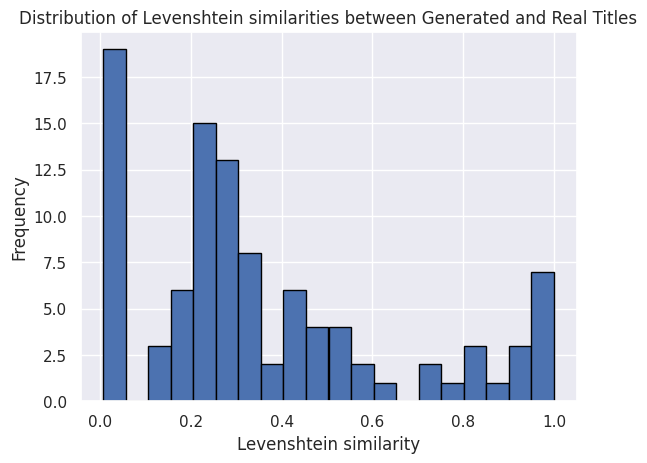

In [23]:
# Visualisation de la distribution des similarité entre les titres générés et les vrais titres
similarities = df_sample["Levenshtein_similarity"]
plt.hist(similarities, bins=20, edgecolor='black')
plt.xlabel('Levenshtein similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Levenshtein similarities between Generated and Real Titles')
plt.show()

### Cosinus similarity : 

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
def cosinus_similarity(str1, str2):
    # Convertir les chaînes de caractères en vecteurs de mots
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([str1, str2])

    # Calculer la similarité cosinus entre les vecteurs
    cosine_sim = cosine_similarity(vectors[0], vectors[1])[0][0]
    
    return cosine_sim

In [26]:
# Exemple d'utilisation
cos_similarity = cosinus_similarity(df_sample.Generated_title_clean[0], df_sample.Title[0])
print("Cos Similarity Score:", cos_similarity)
leven_similarity = calculate_similarity(df_sample.Generated_title_clean[0], df_sample.Title[0])
print("Levenshtein Similarity :", leven_similarity)

Cos Similarity Score: 0.12442854619985261
Levenshtein Similarity : 0.32432432432432434


In [27]:
# Exemple d'utilisation
cos_similarity = cosinus_similarity(df_sample.Generated_title_clean[2], df_sample.Title[2])
print("Cos Similarity Score:", cos_similarity)
leven_similarity = calculate_similarity(df_sample.Generated_title_clean[2], df_sample.Title[2])
print("Levenshtein Similarity :", leven_similarity)

Cos Similarity Score: 1.0000000000000002
Levenshtein Similarity : 0.967741935483871


In [28]:
df_sample["Cos_similarity"] = np.nan
for i in range(len(df_sample)):
    df_sample["Cos_similarity"][i] = cosinus_similarity(df_sample["Generated_title_clean"][i], df_sample["Title"][i])

In [29]:
df_sample.head(5)

,Title,Text,Text_clean,Generated_title,Text_tokens,Text_tokens_clean,Text_tokens_str,Generated_title_clean,Levenshtein_similarity,Cos_similarity
0,Setting up Email Updates for Your Scraper usin...,Photo by Jamie Street on Unsplash\n\nVery ofte...,photo by jamie street on unsplash very often ...,"\nHere is a concise title for the text:\n\n""Se...","['photo', 'by', 'jamie', 'street', 'on', 'unsp...","['photo', 'jamie', 'street', 'unsplash', 'ofte...",photo jamie street unsplash often building web...,"""Sending Emails with Python's smtplib and MIME...",0.324324,0.124429
1,Introduction to Principal Component Analysis,"By In Visal, Yin Seng, Choung Chamnab & Buoy R...",by in visal yin seng choung chamnab buoy rina...,\nTitle: Principal Component Analysis (PCA) in...,"['by', 'in', 'visal', 'yin', 'seng', 'choung',...","['visal', 'yin', 'seng', 'choung', 'chamnab', ...",visal yin seng choung chamnab buoy rina articl...,Principal Component Analysis (PCA) in Data Sci...,0.260274,0.295268
2,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About K-Nea...,everything you ever wanted to know about knear...,"\n""Everything You Ever Wanted to Know About K-...","['everything', 'you', 'ever', 'wanted', 'to', ...","['everything', 'ever', 'wanted', 'know', 'knea...",everything ever wanted know knearest neighbors...,"""Everything You Ever Wanted to Know About K-Ne...",0.967742,1.000000
3,Correlation does not imply causation,Correlation does not imply causation\n\nPhoto ...,correlation does not imply causation photo by...,"\nHere's the concise title for the text:\n\n""C...","['correlation', 'does', 'not', 'imply', 'causa...","['correlation', 'imply', 'causation', 'photo',...",correlation imply causation photo sajjad zabih...,"""Correlation Does Not Imply Causation: The Cas...",0.480000,0.515336
4,Four Mistakes You Make When Labeling Data,White Space\n\nWhite space is hard to see and ...,white space white space is hard to see and ca...,"\nHere is a concise title for the text:\n\n""Th...","['white', 'space', 'white', 'space', 'is', 'ha...","['white', 'space', 'white', 'space', 'hard', '...",white space white space hard see cause confusi...,"""The Invisible Issues of White Space Annotation""",0.291667,0.000000


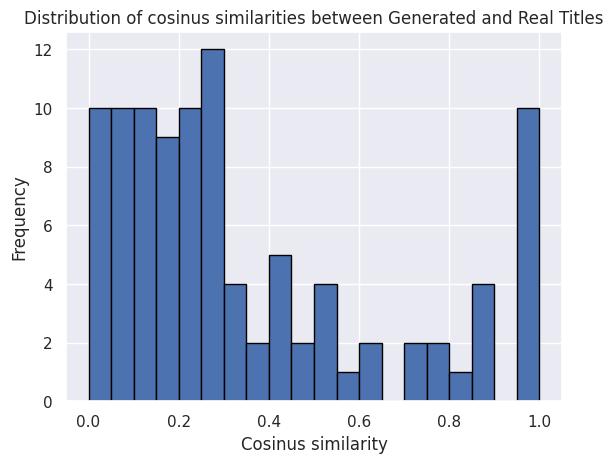

In [30]:
# Visualisation de la distribution des similarité entre les titres générés et les vrais titres
similarities = df_sample["Cos_similarity"]
plt.hist(similarities, bins=20, edgecolor='black')
plt.xlabel('Cosinus similarity')
plt.ylabel('Frequency')
plt.title('Distribution of cosinus similarities between Generated and Real Titles')
plt.show()

In [31]:
df_sample["Cos_similarity"].describe()

count    100.000000
mean       0.353904
std        0.311239
min        0.000000
25%        0.123023
50%        0.253209
75%        0.506055
max        1.000000
Name: Cos_similarity, dtype: float64

In [32]:
for i in range(len(df_sample)):
    if df_sample["Cos_similarity"][i]>0.5:
        print("Cos Similarity :", round(df_sample.Cos_similarity[i],4), " - Lenvenshein Similarity :", round(df_sample.Levenshtein_similarity[i],4))
        print("Generated title : \n", df_sample["Generated_title_clean"][i])
        print("Real title : \n", df_sample["Title"][i])
        print("\n ------------------------------------------------ \n")

Cos Similarity : 1.0  - Lenvenshein Similarity : 0.9677
Generated title : 
 "Everything You Ever Wanted to Know About K-Nearest Neighbors"
Real title : 
 Everything You Ever Wanted to Know About K-Nearest Neighbors

 ------------------------------------------------ 

Cos Similarity : 0.5153  - Lenvenshein Similarity : 0.48
Generated title : 
 "Correlation Does Not Imply Causation: The Case of Smoking and Lung Cancer"
Real title : 
 Correlation does not imply causation

 ------------------------------------------------ 

Cos Similarity : 1.0  - Lenvenshein Similarity : 0.9649
Generated title : 
 "Selenium Tutorial: Scraping Glassdoor.com in 10 Minutes"
Real title : 
 Selenium Tutorial: Scraping Glassdoor.com in 10 Minutes

 ------------------------------------------------ 

Cos Similarity : 0.8955  - Lenvenshein Similarity : 0.9032
Generated title : 
 "Verifying Assumptions of Linear Regression in Python and R"
Real title : 
 Verifying the Assumptions of Linear Regression in Python and 

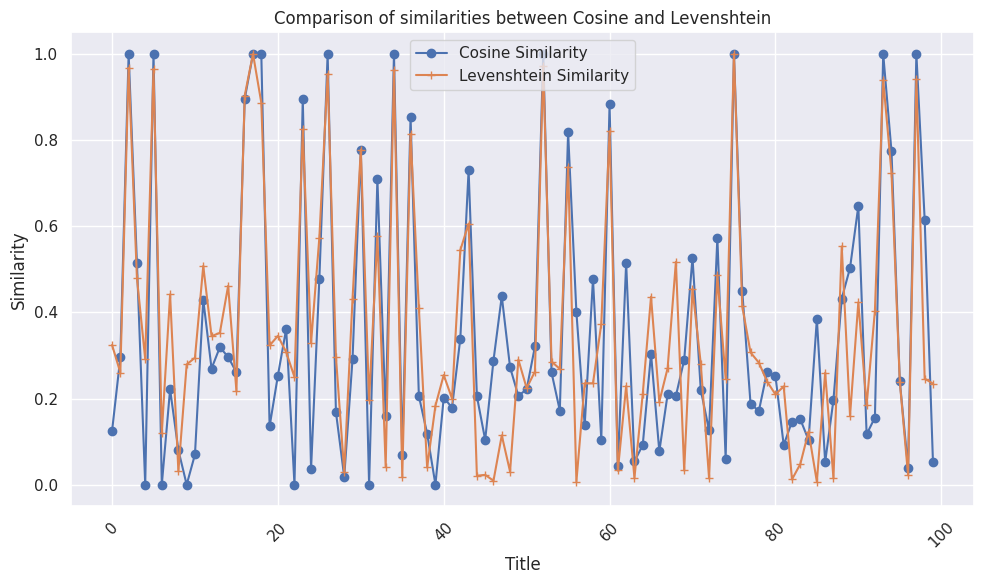

In [33]:
# Visualisation des deux mesures de similarités
similarities_cosine = df_sample["Cos_similarity"]  
similarities_levenshtein = df_sample["Levenshtein_similarity"]

plt.figure(figsize=(10, 6))
plt.plot(similarities_cosine, label='Cosine Similarity', marker='o')
plt.plot(similarities_levenshtein, label='Levenshtein Similarity', marker='+')

plt.xlabel('Title')
plt.ylabel('Similarity')
plt.title('Comparison of similarities between Cosine and Levenshtein')
plt.legend()

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [255]:
df_sample.to_csv("medium_sammple_clean_2.csv", index=False)

## Mistral : Prompt engineering 

In [68]:
text = df_sample.Text_clean[96]

!pip install langchain-experimental

In [78]:
# from langchain_community.chat_models import ChatOllama
# from langchain_core.output_parsers import StrOutputParser

llm = ChatOllama(model='mistral', temperature=0)
prompt = ChatPromptTemplate.from_template("Generate the appropriate title to {text}, the answer must include only the title")

# Without bind.
chain = (
    prompt
    | llm
    | StrOutputParser()
)

chain.invoke({text})




' "Managing the Pains of Moving Beyond Streamlit Prototypes: Best Practices for Building Scalable Data Science Apps"'

In [60]:
# from langchain_community.chat_models import ChatOllama
# from langchain_core.output_parsers import StrOutputParser

llm = ChatOllama(model='llama2:13b', temperature=0)
prompt = ChatPromptTemplate.from_template("generate a 10 words appropriate title to the quoted text '{text}' ")
# Without bind.
chain = (
    prompt
    | llm
    | StrOutputParser()
)
chain.invoke({text})

'\nThe article discusses best practices for using Streamlit for data science prototyping and how to transition from a prototype to a production-ready application. The author highlights three key benefits of using Streamlit:\n\n1. Interactive visualizations: Streamlit allows users to create interactive visualizations that can be easily shared and explored.\n2. Easy to use: Streamlit is designed to be easy to use, even for those without extensive coding knowledge.\n3. Flexible: Streamlit can be used to build a wide range of applications, from simple data visualizations to complex machine learning models.\n\nThe author also discusses some potential pain points when transitioning from a prototype to a production-ready application, such as code organization and debugging. To address these issues, the author recommends refactoring the code, creating functions, and testing the application. The article concludes by emphasizing the importance of good code hygiene and provides an exercise to hel

In [53]:
df_sample.Title[96]

'Intermediate Streamlit'

In [106]:
def generate_title(text, llm_model="mistral"):
    llm = ChatOllama(model=llm_model,
                     temperature=0
                    )
    prompt = ChatPromptTemplate.from_template("Generate the appropriate title to {text}, the answer must include only the title")
    chain = (
        prompt 
        | llm 
        | StrOutputParser()
    )
    return chain.invoke({text})

In [125]:
generate_title(df_sample2.Text_clean[96])

' "Managing the Pains of Moving Beyond Streamlit Prototypes: Best Practices for Data Science Apps"'

In [109]:
df_sample2 = df_sample.copy()

In [111]:
df_sample2["Generated_title"]=np.nan
df_sample2["Levenshtein_similarity"]=np.nan
df_sample2["Cos_similarity"]=np.nan
df_sample2.head(5)

,Title,Text,Text_clean,Generated_title,Text_tokens,Text_tokens_clean,Text_tokens_str,Generated_title_clean,Levenshtein_similarity,Cos_similarity
0,Setting up Email Updates for Your Scraper usin...,Photo by Jamie Street on Unsplash\n\nVery ofte...,photo by jamie street on unsplash very often ...,NaN,"['photo', 'by', 'jamie', 'street', 'on', 'unsp...","['photo', 'jamie', 'street', 'unsplash', 'ofte...",photo jamie street unsplash often building web...,"""Sending Emails with Python's smtplib and MIME...",NaN,NaN
1,Introduction to Principal Component Analysis,"By In Visal, Yin Seng, Choung Chamnab & Buoy R...",by in visal yin seng choung chamnab buoy rina...,NaN,"['by', 'in', 'visal', 'yin', 'seng', 'choung',...","['visal', 'yin', 'seng', 'choung', 'chamnab', ...",visal yin seng choung chamnab buoy rina articl...,Principal Component Analysis (PCA) in Data Sci...,NaN,NaN
2,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About K-Nea...,everything you ever wanted to know about knear...,NaN,"['everything', 'you', 'ever', 'wanted', 'to', ...","['everything', 'ever', 'wanted', 'know', 'knea...",everything ever wanted know knearest neighbors...,"""Everything You Ever Wanted to Know About K-Ne...",NaN,NaN
3,Correlation does not imply causation,Correlation does not imply causation\n\nPhoto ...,correlation does not imply causation photo by...,NaN,"['correlation', 'does', 'not', 'imply', 'causa...","['correlation', 'imply', 'causation', 'photo',...",correlation imply causation photo sajjad zabih...,"""Correlation Does Not Imply Causation: The Cas...",NaN,NaN
4,Four Mistakes You Make When Labeling Data,White Space\n\nWhite space is hard to see and ...,white space white space is hard to see and ca...,NaN,"['white', 'space', 'white', 'space', 'is', 'ha...","['white', 'space', 'white', 'space', 'hard', '...",white space white space hard see cause confusi...,"""The Invisible Issues of White Space Annotation""",NaN,NaN


In [121]:
for i in range (len(df_sample2)):
    df_sample2.Generated_title[i] = generate_title(df_sample2.Text_clean[i])

In [256]:
for i in range (0,21):
    print(i, "- Titre généré :\n", df_sample2.Generated_title[i])
    print("Titre réel :\n", df_sample2.Title[i])
    print("\n ---------------------------------------- \n")

0 - Titre généré :
  "Sending Automatic Real-time Reports from Web Scraping Scripts using Python and Gmail SMTP"
Titre réel :
 Setting up Email Updates for Your Scraper using Python and a Gmail Account

 ---------------------------------------- 

1 - Titre généré :
  "Principal Component Analysis (PCA): Extracting Hidden Structures from Confusing Data Sets using Orthogonal Projection"
Titre réel :
 Introduction to Principal Component Analysis

 ---------------------------------------- 

2 - Titre généré :
  "An Overview of K-Nearest Neighbors: A Simple Machine Learning Algorithm for Classification"
Titre réel :
 Everything You Ever Wanted to Know About K-Nearest Neighbors

 ---------------------------------------- 

3 - Titre généré :
  "Correlation Between Smoking and Lung Cancer: Fisher's Skepticism and the Establishment of Causation"

or

"Smoking and Lung Cancer: The Debate over Correlation and Causation in the 1950s and 60s"

or

"The Controversial Connection: Smoking, Lung Cancer

### Autre essai : Mistral 

In [244]:
def completion_title(text, llm_model="mistral"):
    llm = ChatOllama(model=llm_model,
                     temperature=0
                    )
    prompt = ChatPromptTemplate.from_template("<s>[INST] Generate the appropriate title to the following text :[/INST]{text}.</s>\
    [INST ]Just generate a short title, do no provide explanations\
    The response must be as short as possible and contains only one title.[/INST]")
    chain = (
        prompt 
        | llm 
        | StrOutputParser()
    )
    return chain.invoke({text})

In [242]:
df_sample2["Generated_title_2"]=np.nan

In [247]:
for i in range (len(df_sample2)):
    df_sample2.Generated_title_2[i] = completion_title(df_sample2.Text_clean[i])

In [248]:
df_sample2.head(5)

,Title,Text,Text_clean,Generated_title,Text_tokens,Text_tokens_clean,Text_tokens_str,Generated_title_clean,Levenshtein_similarity,Cos_similarity,Generated_title_2
0,Setting up Email Updates for Your Scraper usin...,Photo by Jamie Street on Unsplash\n\nVery ofte...,photo by jamie street on unsplash very often ...,"""Sending Automatic Real-time Reports from Web...","['photo', 'by', 'jamie', 'street', 'on', 'unsp...","['photo', 'jamie', 'street', 'unsplash', 'ofte...",photo jamie street unsplash often building web...,"""Sending Emails with Python's smtplib and MIME...",NaN,NaN,"""Sending Email Reports from Python Web Scrape..."
1,Introduction to Principal Component Analysis,"By In Visal, Yin Seng, Choung Chamnab & Buoy R...",by in visal yin seng choung chamnab buoy rina...,"""Principal Component Analysis (PCA): Extracti...","['by', 'in', 'visal', 'yin', 'seng', 'choung',...","['visal', 'yin', 'seng', 'choung', 'chamnab', ...",visal yin seng choung chamnab buoy rina articl...,Principal Component Analysis (PCA) in Data Sci...,NaN,NaN,"""Principal Component Analysis: Extracting Hid..."
2,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About K-Nea...,everything you ever wanted to know about knear...,"""An Overview of K-Nearest Neighbors: A Simple...","['everything', 'you', 'ever', 'wanted', 'to', ...","['everything', 'ever', 'wanted', 'know', 'knea...",everything ever wanted know knearest neighbors...,"""Everything You Ever Wanted to Know About K-Ne...",NaN,NaN,"""An Overview of K-Nearest Neighbors Algorithm"""
3,Correlation does not imply causation,Correlation does not imply causation\n\nPhoto ...,correlation does not imply causation photo by...,"""Correlation Between Smoking and Lung Cancer:...","['correlation', 'does', 'not', 'imply', 'causa...","['correlation', 'imply', 'causation', 'photo',...",correlation imply causation photo sajjad zabih...,"""Correlation Does Not Imply Causation: The Cas...",NaN,NaN,"""Correlation vs. Causation: Smoking and Lung ..."
4,Four Mistakes You Make When Labeling Data,White Space\n\nWhite space is hard to see and ...,white space white space is hard to see and ca...,Title: Managing White Space and Punctuation I...,"['white', 'space', 'white', 'space', 'is', 'ha...","['white', 'space', 'white', 'space', 'hard', '...",white space white space hard see cause confusi...,"""The Invisible Issues of White Space Annotation""",NaN,NaN,"""Whitespace Annotation Consistency: Trailing ..."


In [249]:
for i in range (0,31):
    print(i, "- Titre généré :\n", df_sample2.Generated_title_2[i])
    print("Titre réel :\n", df_sample2.Title[i])
    print("\n ---------------------------------------- \n")

0 - Titre généré :
  "Sending Email Reports from Python Web Scrapers using SMTP"
Titre réel :
 Setting up Email Updates for Your Scraper using Python and a Gmail Account

 ---------------------------------------- 

1 - Titre généré :
  "Principal Component Analysis: Extracting Hidden Structures from Complex Data"
Titre réel :
 Introduction to Principal Component Analysis

 ---------------------------------------- 

2 - Titre généré :
  "An Overview of K-Nearest Neighbors Algorithm"
Titre réel :
 Everything You Ever Wanted to Know About K-Nearest Neighbors

 ---------------------------------------- 

3 - Titre généré :
  "Correlation vs. Causation: Smoking and Lung Cancer" or "Smoking and Lung Cancer: Correlation or Causation?"
Titre réel :
 Correlation does not imply causation

 ---------------------------------------- 

4 - Titre généré :
  "Whitespace Annotation Consistency: Trailing and Leading Spaces"
Titre réel :
 Four Mistakes You Make When Labeling Data

 -----------------------

In [252]:
for i in range (31,61):
    print(i, "- Titre généré :\n", df_sample2.Generated_title_2[i])
    print("Titre réel :\n", df_sample2.Title[i])
    print("\n ---------------------------------------- \n")

31 - Titre généré :
  "Deep Learning for Diabetic Retinopathy Image Classification: APTOS 2019 Competition"
Titre réel :
 APTOS 2019 Blindness Detection

 ---------------------------------------- 

32 - Titre généré :
  "Python Decorators: Implementing a Function Timing Decorator"
Titre réel :
 Decorating functions in Python

 ---------------------------------------- 

33 - Titre généré :
  "Personalized Road Safety Alerts using Car Data"
Titre réel :
 Our HackZurich Adventure — How Data Can Save Lives on the Roads

 ---------------------------------------- 

34 - Titre généré :
  "Personalizing the Customer Experience: Hearing Their Names" or "The Power of Personalization in Customer Experience"
Titre réel :
 Reinventing Personalization For Customer Experience

 ---------------------------------------- 

35 - Titre généré :
  "Text Data Analysis: Classifying YouTube Categories with LSTM"
Titre réel :
 Analyzing Text Classification Techniques on Youtube Data

 -------------------------

In [253]:
for i in range (61,99):
    print(i, "- Titre généré :\n", df_sample2.Generated_title_2[i])
    print("Titre réel :\n", df_sample2.Title[i])
    print("\n ---------------------------------------- \n")

61 - Titre généré :
  "Understanding Word Embeddings in Deep Learning for NLP"
Titre réel :
 Reimagining Plutarch with Tensorflow 2.0

 ---------------------------------------- 

62 - Titre généré :
  "The Traps of Data Exploration in Machine Learning"
Titre réel :
 Lessons from a real Machine Learning project, part 2: the traps of data exploration

 ---------------------------------------- 

63 - Titre généré :
  Data Exploration and Feature Engineering for San Francisco Crime Classification
Titre réel :
 Deep Dive into SF Crime

 ---------------------------------------- 

64 - Titre généré :
  "Living with Artificially Intelligent Coworkers: Benefits and Challenges"
Titre réel :
 What if Your Colleague is a Robot

 ---------------------------------------- 

65 - Titre généré :
  "Deploying a Sentiment Analysis Model on Amazon Sagemaker"
Titre réel :
 How To Build a Model on SageMaker

 ---------------------------------------- 

66 - Titre généré :
  "Boosting: Combining Weak Learners

In [269]:
def clean_title(title):
    # Supprimer les introductions inutiles
    cleaned_title = re.sub(r'Note:.*$', '', title)
    # Supprmier les propositions pour ne garder que le premier titre proposé
    cleaned_title = re.sub(r'or ".*$', '', cleaned_title)
    cleaned_title = re.sub(r'\n\nOr\n\n.*$', '', cleaned_title)    
    # Supprimer les espaces en début et fin de chaîne
    cleaned_title = cleaned_title.strip()
    return cleaned_title

In [270]:
df_sample2["Generated_title_clean"] = df_sample2["Generated_title_2"].apply(clean_title)

In [271]:
df_sample2.head(5)

,Title,Text,Text_clean,Generated_title,Text_tokens,Text_tokens_clean,Text_tokens_str,Generated_title_clean,Levenshtein_similarity,Cos_similarity,Generated_title_2
0,Setting up Email Updates for Your Scraper usin...,Photo by Jamie Street on Unsplash\n\nVery ofte...,photo by jamie street on unsplash very often ...,"""Sending Automatic Real-time Reports from Web...","['photo', 'by', 'jamie', 'street', 'on', 'unsp...","['photo', 'jamie', 'street', 'unsplash', 'ofte...",photo jamie street unsplash often building web...,"""Sending Email Reports from Python Web Scraper...",NaN,NaN,"""Sending Email Reports from Python Web Scrape..."
1,Introduction to Principal Component Analysis,"By In Visal, Yin Seng, Choung Chamnab & Buoy R...",by in visal yin seng choung chamnab buoy rina...,"""Principal Component Analysis (PCA): Extracti...","['by', 'in', 'visal', 'yin', 'seng', 'choung',...","['visal', 'yin', 'seng', 'choung', 'chamnab', ...",visal yin seng choung chamnab buoy rina articl...,"""Principal Component Analysis: Extracting Hidd...",NaN,NaN,"""Principal Component Analysis: Extracting Hid..."
2,Everything You Ever Wanted to Know About K-Nea...,Everything You Ever Wanted to Know About K-Nea...,everything you ever wanted to know about knear...,"""An Overview of K-Nearest Neighbors: A Simple...","['everything', 'you', 'ever', 'wanted', 'to', ...","['everything', 'ever', 'wanted', 'know', 'knea...",everything ever wanted know knearest neighbors...,"""An Overview of K-Nearest Neighbors Algorithm""",NaN,NaN,"""An Overview of K-Nearest Neighbors Algorithm"""
3,Correlation does not imply causation,Correlation does not imply causation\n\nPhoto ...,correlation does not imply causation photo by...,"""Correlation Between Smoking and Lung Cancer:...","['correlation', 'does', 'not', 'imply', 'causa...","['correlation', 'imply', 'causation', 'photo',...",correlation imply causation photo sajjad zabih...,"""Correlation vs. Causation: Smoking and Lung C...",NaN,NaN,"""Correlation vs. Causation: Smoking and Lung ..."
4,Four Mistakes You Make When Labeling Data,White Space\n\nWhite space is hard to see and ...,white space white space is hard to see and ca...,Title: Managing White Space and Punctuation I...,"['white', 'space', 'white', 'space', 'is', 'ha...","['white', 'space', 'white', 'space', 'hard', '...",white space white space hard see cause confusi...,"""Whitespace Annotation Consistency: Trailing a...",NaN,NaN,"""Whitespace Annotation Consistency: Trailing ..."


In [274]:
for i in range(len(df_sample2)):
    df_sample2["Levenshtein_similarity"][i] = calculate_similarity(df_sample2["Generated_title_clean"][i], df_sample2["Title"][i])

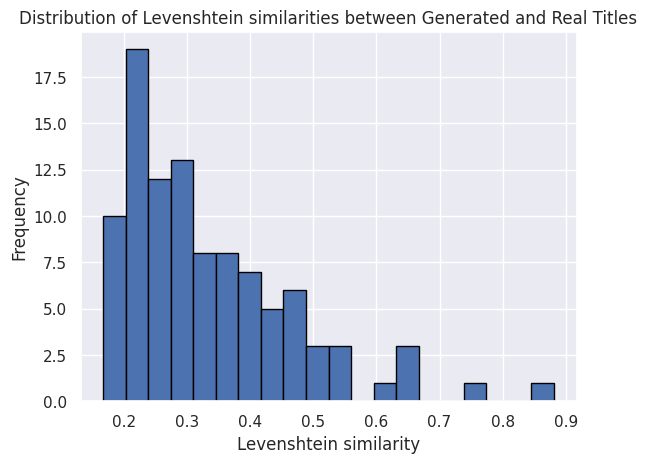

count    100.000000
mean       0.336098
std        0.136865
min        0.166667
25%        0.229440
50%        0.299663
75%        0.412272
max        0.881356
Name: Levenshtein_similarity, dtype: float64

In [278]:
# Visualisation de la distribution des similarité entre les titres générés et les vrais titres
similarities = df_sample2["Levenshtein_similarity"]
plt.hist(similarities, bins=20, edgecolor='black')
plt.xlabel('Levenshtein similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Levenshtein similarities between Generated and Real Titles')
plt.show()

df_sample2["Levenshtein_similarity"].describe()

In [276]:
for i in range(len(df_sample2)):
    df_sample2["Cos_similarity"][i] = cosinus_similarity(df_sample2["Generated_title_clean"][i], df_sample2["Title"][i])

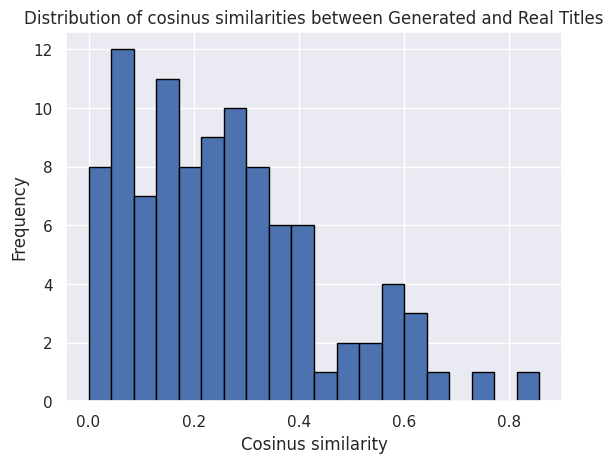

count    100.000000
mean       0.259179
std        0.184159
min        0.000000
25%        0.122829
50%        0.238249
75%        0.344847
max        0.857761
Name: Cos_similarity, dtype: float64

In [279]:
# Visualisation de la distribution des similarité entre les titres générés et les vrais titres
similarities = df_sample2["Cos_similarity"]
plt.hist(similarities, bins=20, edgecolor='black')
plt.xlabel('Cosinus similarity')
plt.ylabel('Frequency')
plt.title('Distribution of cosinus similarities between Generated and Real Titles')
plt.show()

df_sample2["Cos_similarity"].describe()

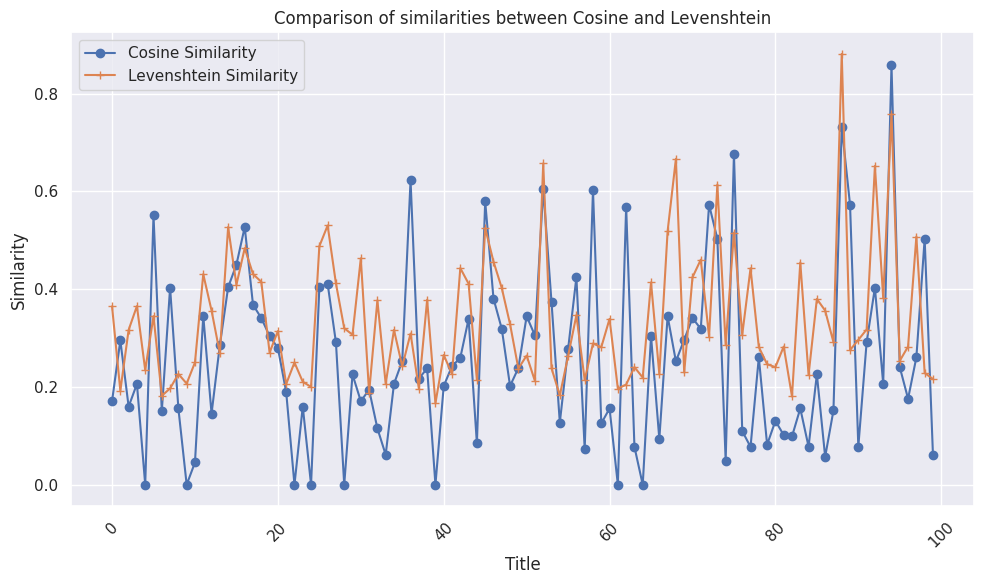

In [288]:
# Visualisation des deux mesures de similarités
similarities_cosine = df_sample2["Cos_similarity"]  
similarities_levenshtein = df_sample2["Levenshtein_similarity"]

plt.figure(figsize=(10, 6))
plt.plot(similarities_cosine, label='Cosine Similarity', marker='o')
plt.plot(similarities_levenshtein, label='Levenshtein Similarity', marker='+')

plt.xlabel('Title')
plt.ylabel('Similarity')
plt.title('Comparison of similarities between Cosine and Levenshtein')
plt.legend()

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

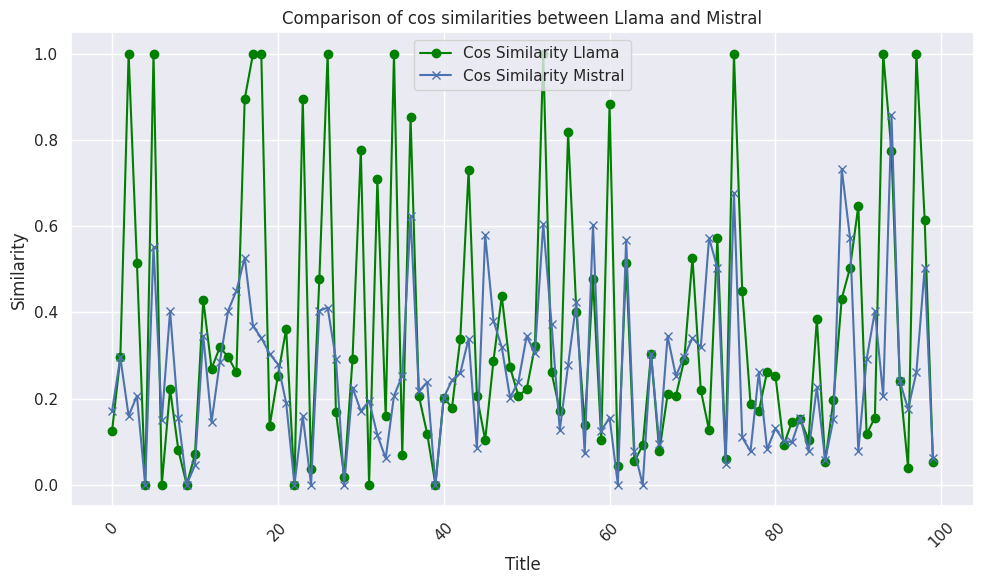

In [291]:
# Visualisation des deux mesures de similarités
similarities_cos_llama = df_sample["Cos_similarity"]  
similarities_cos_mistral = df_sample2["Cos_similarity"]

plt.figure(figsize=(10, 6))
plt.plot(similarities_cos_llama, label='Cos Similarity Llama', marker='o', color='green')
plt.plot(similarities_cos_mistral, label='Cos Similarity Mistral', marker='x')

plt.xlabel('Title')
plt.ylabel('Similarity')
plt.title('Comparison of cos similarities between Llama and Mistral')
plt.legend()

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

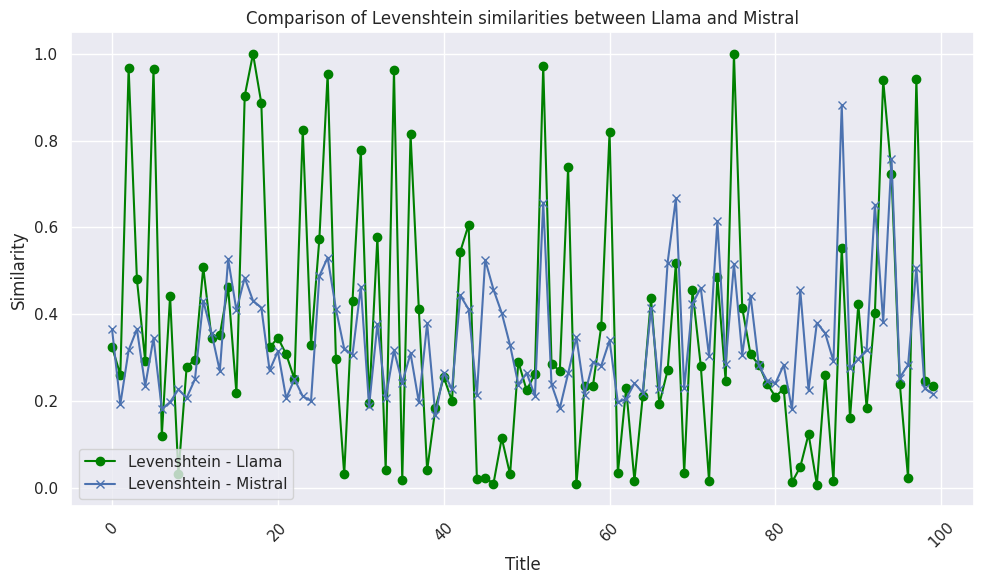

In [292]:
# Visualisation des deux mesures de similarités
similarities_leven_llama = df_sample["Levenshtein_similarity"]  
similarities_leven_mistral = df_sample2["Levenshtein_similarity"]

plt.figure(figsize=(10, 6))
plt.plot(similarities_leven_llama, label='Levenshtein - Llama', marker='o', color='green')
plt.plot(similarities_leven_mistral, label='Levenshtein - Mistral', marker='x')

plt.xlabel('Title')
plt.ylabel('Similarity')
plt.title('Comparison of Levenshtein similarities between Llama and Mistral')
plt.legend()

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La mesure de similarité basée sur la distance de Levenshtein avec le modèle Llama2:13b prends des valeurs réparties entre 0 et 1 compris, tandis qu'avec le modèle Mistral ces valeurs sont plutôt concentrées dans l'intervalle [0.2 ; 0.6]

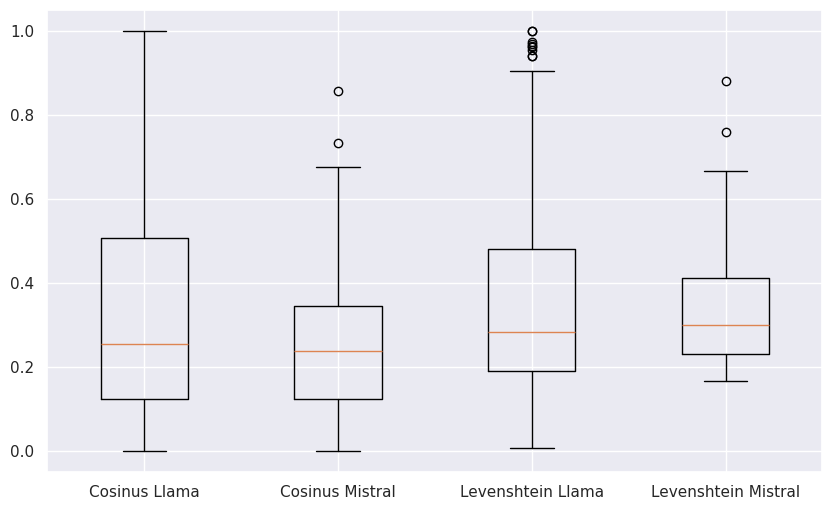

In [306]:
to_box_plot= [df_sample["Cos_similarity"], df_sample2["Cos_similarity"], df_sample["Levenshtein_similarity"], df_sample2["Levenshtein_similarity"]  ]
plt.figure(figsize=(10,6))
plt.boxplot(to_box_plot)
plt.xticks([1, 2, 3, 4],["Cosinus Llama", "Cosinus Mistral", "Levenshtein Llama", "Levenshtein Mistral"])
plt.show()

### Ajout d'un exemple dans le prompt :

In [422]:
def generate_title_function(text, llm_model="mistral"):
    llm = ChatOllama(model=llm_model,
                     temperature=0
                    )
    prompt = ChatPromptTemplate.from_template(""" <s>[INST] You are a helpful assistant.\
    Your task is to generate an appropriate title based on the data science given text.\
    Assuming that the reader is familiar with machine learning and deep learning, do not provide explanations or notes.\
    Your response must only contain a title in one sentence with a maximum of 10 words.
    
    So, for example, for the following text :
    
    In my last article, I introduced the concept of Graph Neural Network (GNN) and some recent advancements of it.\
    Since this topic is getting seriously hyped up, I decided to make this tutorial on how to easily implement your Graph Neural Network in your project.\
    You will learn how to construct your own GNN with PyTorch Geometric, and how to use GNN to solve a real-world problem (Recsys Challenge 2015).\
    In this blog post, we will be using PyTorch and PyTorch Geometric (PyG), a Graph Neural Network framework built on top of PyTorch that runs \
    blazingly fast. It is several times faster than the most well-known GNN framework, DGL.\
    Aside from its remarkable speed, PyG comes with a collection of well-implemented GNN models illustrated in various papers.\
    Therefore, it would be very handy to reproduce the experiments with PyG.
    
    the title would be :
    Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric
    [/INST]
    </s>
    [INST]
    {text}
    [/INST]
    """)
    chain = (
        prompt 
        | llm 
        | StrOutputParser()
    )
    return chain.invoke({text})

In [ ]:
data["Generated_title"]=np.nan
for i in range (len(data)):
    data.Generated_title[i] = generate_title_function(data.Text_clean[i], llm_model="mistral")

In [439]:
data.head(150)

,Title,Text,Text_clean,Generated_title
0,A Beginner’s Guide to Word Embedding with Gens...,1. Introduction of Word2vec\n\nWord2vec is one...,Introduction of Word2vec Word2vec is one of t...,This code snippet is written in Python and us...
1,Hands-on Graph Neural Networks with PyTorch & ...,"In my last article, I introduced the concept o...","In my last article, I introduced the concept o...",Implementing Graph Neural Networks with PyTor...
2,How to Use ggplot2 in Python,Introduction\n\nThanks to its strict implement...,Introduction Thanks to its strict implementat...,Exploring Data Visualization with Python's Pl...
3,Databricks: How to Save Data Frames as CSV Fil...,Photo credit to Mika Baumeister from Unsplash\...,Photo credit to Mika Baumeister from Unsplash ...,Saving Data Frames from Databricks to CSV: A ...
4,A Step-by-Step Implementation of Gradient Desc...,A Step-by-Step Implementation of Gradient Desc...,A Step-by-Step Implementation of Gradient Desc...,Deriving Gradient Descent and Backpropagation...
...,...,...,...,...
145,Interactive Visualization with Dash and Plotly,Interactive data visualization has an importan...,Interactive data visualization has an importan...,It looks like you have written a Dash applica...
146,Information Entropy,Information Entropy\n\nIf you were to watch me...,Information Entropy If you were to watch me c...,NaN
147,Can You Tell Random and Non-Random Apart?,Photo by Alejandro Luengo on Unsplash\n\nApoph...,Photo by Alejandro Luengo on Unsplash Apophen...,NaN
148,Classic Cryptography Systems,Written communication is found in every instan...,Written communication is found in every instan...,NaN


In [450]:
for i in range(21):
    print(i, " - Generated title : \n", data.Generated_title[i])
    print("Real title : \n", data.Title[i])
    print("\n ------------------------------------------------ \n")

0  - Generated title : 
  This code snippet is written in Python and uses the Word2Vec model from the gensim library to analyze make models and their similarities based on a given dataset. The script starts by importing necessary libraries, loading the dataset into a pandas DataFrame, and preprocessing the data by converting the Maker\_Model column into a list of unique values.

Next, it initializes the Word2Vec model with the size of 100 for each dimension and trains it on the preprocessed data. After training, the script generates the most similar make models based on cosine similarity using a custom function called `cosine_distance`. Finally, it visualizes the word embedding with T-SNE plot using a custom function called `display_closestwords_tsnescatterplot`.

The provided code snippet is useful for analyzing and understanding the relationships between different make models based on their textual descriptions. It can be applied to various industries, such as automotive or real esta

In [441]:
data.to_csv("data_generated_title_1.csv", index=False)

In [442]:
generate_title_function(data.Text_clean[200], llm_model="mistral")

' Predicting Subscriber Growth with TensorFlow: A Machine Learning Approach'

In [443]:
data.Title[200]

'Build your first Machine Learning Model using TensorFlow'

In [444]:
generate_title_function(data.Text_clean[300])

" Exploring Singapore's Changing Weather Patterns with Plotly Express"

In [445]:
data.Title[300]

'Visualising Singapore’s changing weather patterns: 1983–2019'

In [446]:
generate_title_function(data.Text_clean[146])

' Entropy and Information: Measuring Uncertainty in Russian Roulette and English Language\n\n[Or]\n\nExploring Entropy: From Russian Roulette to the English Language\n\n[Or]\n\nEntropy: Quantifying Unpredictability in Russian Roulette and English Texts'

In [ ]:
# Your response must contain just one title in one sentence, do not exceed 10 words.

In [6]:
def func_generate_title(text, llm_model="mistral"):
    llm = ChatOllama(model=llm_model,
                     temperature=0
                    )
    prompt = ChatPromptTemplate.from_template(""" <s>[INST] You are a helpful assistant.
    Your task is to generate an appropriate title based on the given text.
    Do not provide multiple suggestions, no explanations and no notes.
    The title should be concise and captures the essence of the text. 
    
    So, for example, for the following text :
    
    In my last article, I introduced the concept of Graph Neural Network (GNN) and some recent advancements of it.\
    Since this topic is getting seriously hyped up, I decided to make this tutorial on how to easily implement your Graph Neural Network in your project.\
    You will learn how to construct your own GNN with PyTorch Geometric, and how to use GNN to solve a real-world problem (Recsys Challenge 2015).\
    In this blog post, we will be using PyTorch and PyTorch Geometric (PyG), a Graph Neural Network framework built on top of PyTorch that runs \
    blazingly fast. It is several times faster than the most well-known GNN framework, DGL.\
    Aside from its remarkable speed, PyG comes with a collection of well-implemented GNN models illustrated in various papers.\
    Therefore, it would be very handy to reproduce the experiments with PyG.
    
    the title should be :[/INST]
    Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric
    </s>
    [INST]
    {text}
    [/INST]
    """)
    chain = (
        prompt 
        | llm 
        | StrOutputParser()
    )
    return chain.invoke({text})

In [7]:
def func_generate_title2(text, llm_model="mistral"):
    llm = ChatOllama(model=llm_model,
                     temperature=0.9
                    )
    prompt = ChatPromptTemplate.from_template(""" <s>[INST] You are a helpful assistant.
    Your task is to generate an appropriate title based on the given text.
    Just provide one suggestion, no explanations and no notes.
    The title should be concise and captures the essence of the text. 
    
    So, for example, for the following text :
    
    In my last article, I introduced the concept of Graph Neural Network (GNN) and some recent advancements of it.\
    Since this topic is getting seriously hyped up, I decided to make this tutorial on how to easily implement your Graph Neural Network in your project.\
    You will learn how to construct your own GNN with PyTorch Geometric, and how to use GNN to solve a real-world problem (Recsys Challenge 2015).\
    In this blog post, we will be using PyTorch and PyTorch Geometric (PyG), a Graph Neural Network framework built on top of PyTorch that runs \
    blazingly fast. It is several times faster than the most well-known GNN framework, DGL.\
    Aside from its remarkable speed, PyG comes with a collection of well-implemented GNN models illustrated in various papers.\
    Therefore, it would be very handy to reproduce the experiments with PyG.
    
    the title should be :[/INST]
    Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric
    </s>
    [INST]
    {text}
    [/INST]
    """)
    chain = (
        prompt 
        | llm 
        | StrOutputParser()
    )
    return chain.invoke({text})

In [473]:
for i in range(5):
    generated_title = func_generate_title2(data.Text_clean[i], llm_model="mistral")
    while " or " in generated_title:
        generated_title = func_generate_title2(data.Text_clean[i], llm_model="mistral")
    data.Generated_title[i] = generated_title

    print(i, " - Generated title : \n", data.Generated_title[i])
    print("Real title : \n", data.Title[i])
    print("\n ------------------------------------------------ \n")

0  - Generated title : 
  It looks like you have written a Python script that utilizes Word2Vec and T-SNE for text analysis, specifically to analyze make models from an automobile dataset. The script begins by importing necessary libraries such as NumPy, pandas, gensim, and sklearn.next()

The data is loaded into a DataFrame named `df`, and the unique make model list is stored in a variable named `Maker_Model`. You then proceed to perform text preprocessing such as converting words to lowercase and removing stopwords using NLTK. This preprocessed data is then used to generate Word2Vec model using gensim library's Word2Vec model with size 100, window 5, min_count 1 and workers 4.

After generating the Word2Vec model, you perform text analysis such as calculating cosine distance between different make models for Mercedes-Benz SLK-Class. Additionally, you visualize the most similar make models using a T-SNE scatterplot. The script also includes a function `display_closestwords_tsnescatter

In [474]:
print(func_generate_title2(data.Text_clean[6]), len((func_generate_title2(data.Text_clean[6])).split()))

 Visual Guide to Hypothesis Testing: Rejecting the Null Hypothesis with Data
    
(or)

Exploring Hypothesis Testing through Visuals: When to Reject the Null Hypothesis? 23


In [484]:
for i in range(1,6):
    generated_title = func_generate_title2(data.Text_clean[i], llm_model="mistral")
    while " or " in generated_title or "\nor\n" in generated_title or "[or]" in generated_title:
        generated_title = func_generate_title2(data.Text_clean[i], llm_model="mistral")
    data.Generated_title[i] = generated_title

    print(i, " - Generated title : \n", data.Generated_title[i])
    print("Real title : \n", data.Title[i])
    print("\n ------------------------------------------------ \n")

1  - Generated title : 
  "Implementing Graph Neural Networks with PyTorch Geometric: A Fast and Comprehensive Guide"
Real title : 
 Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric

 ------------------------------------------------ 

2  - Generated title : 
  "Visualizing Data with Python's Plotnine: A ggplot2 Alternative using the Grammar of Graphics"
Real title : 
 How to Use ggplot2 in Python

 ------------------------------------------------ 

3  - Generated title : 
  Saving Data Frames as CSV from Databricks: A Step-by-Step Guide
Real title : 
 Databricks: How to Save Data Frames as CSV Files on Your Local Computer

 ------------------------------------------------ 

4  - Generated title : 
  Understanding Gradient Descent and Backpropagation in Neural Networks: A Step-by-Step Guide with Code Example
Real title : 
 A Step-by-Step Implementation of Gradient Descent and Backpropagation

 ------------------------------------------------ 

5  - Generated title : 
  SQ

In [485]:
for i in range(1,6):
    generated_title = func_generate_title2(data.Text_clean[i], llm_model="mistral")
    while " or " in generated_title or "\nor\n" in generated_title or "[or]" in generated_title or len(generated_title.split()) > 15:
        generated_title = func_generate_title2(data.Text_clean[i], llm_model="mistral")
    data.Generated_title[i] = generated_title

    print(i, " - Generated title : \n", data.Generated_title[i])
    print("Real title : \n", data.Title[i])
    print("\n ------------------------------------------------ \n")

1  - Generated title : 
  "Implementing Graph Neural Networks with PyTorch Geometric: A Fast and Comprehensive Guide"
Real title : 
 Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric

 ------------------------------------------------ 

2  - Generated title : 
  Plotting with Python: A ggplot2-like Experience using plotnine & the Grammar of Graphics
Real title : 
 How to Use ggplot2 in Python

 ------------------------------------------------ 

3  - Generated title : 
  Saving Data Frames as CSV in Databricks: A Step-by-Step Guide
Real title : 
 Databricks: How to Save Data Frames as CSV Files on Your Local Computer

 ------------------------------------------------ 

4  - Generated title : 
  Understanding Gradient Descent and Backpropagation in a Neural Network: A Step-by-Step Python Implementation
Real title : 
 A Step-by-Step Implementation of Gradient Descent and Backpropagation

 ------------------------------------------------ 

5  - Generated title : 
  SQL for Dat

In [ ]:
for i in range(6,101):
    generated_title = func_generate_title2(data.Text_clean[i], llm_model="mistral")
    while " or " in generated_title or "\nor\n" in generated_title or "[or]" in generated_title or len(generated_title.split()) > 15:
        generated_title = func_generate_title2(data.Text_clean[i], llm_model="mistral")
    data.Generated_title[i] = generated_title

In [488]:
df_sample.to_csv("df_sample1.csv", index=False)

In [489]:
df_sample2.to_csv("df_sample2.csv", index=False)

In [492]:
for i in range(6,31):
    print(i, " - Generated title : \n", data.Generated_title[i])
    print("Real title : \n", data.Title[i])
    print("\n ------------------------------------------------ \n")

6  - Generated title : 
  Visual Guide to Hypothesis Testing: Rejecting the Null Hypothesis with Data Examples
Real title : 
 Hypothesis testing visualized

 ------------------------------------------------ 

7  - Generated title : 
  "Probabilistic Matrix Factorization for Recommender Systems: Understanding Latent Factors and their Role"
Real title : 
 Introduction to Latent Matrix Factorization Recommender Systems

 ------------------------------------------------ 

8  - Generated title : 
  The Most Active and Followed Democratic Candidates on Twitter: A Data Analysis (2020)
Real title : 
 Which 2020 Candidate is the Best at Twitter?

 ------------------------------------------------ 

9  - Generated title : 
  This text appears to be a blog post or article about the "What-If Tool" developed by Google. The author, Cassie Kozyrkov, is introducing and explaining the features and capabilities of the tool, as well as addressing potential criticisms and limitations. The tool allows users

# Llama2:13B

In [36]:
def generate_title_donot(text, llm_model="llama2:13b"):
    llm = ChatOllama(model=llm_model, temperature=0, device="cuda")
    
    prompt = ChatPromptTemplate.from_template(""" <s>[INST] You are a helpful assistant.
    Your task is to generate a title based on the given text. Do not exceed 10 words.
    Do not provide explanations or notes. Do not provide multiple propositions. 
    [/INST]</s>
    [INST]
    {text}
    [/INST]
    """)
    chain = (prompt | llm | StrOutputParser())
    return chain.invoke({text})

Application de la fonction à l'ensemble du dataset, avec le modèle LLama2 - 13B

In [46]:
%%time
data['Llama_title_13b']= data['Text'].apply(generate_title_donot)

CPU times: user 6.99 s, sys: 818 ms, total: 7.81 s
Wall time: 1h 9min 57s


In [50]:
data["Len_llama_title"]= data["Llama_title_13b"].apply(count_word_text)

In [52]:
data.Len_llama_title.describe()

count    923.000000
mean       8.299025
std       28.888511
min        2.000000
25%        5.000000
50%        6.000000
75%        8.000000
max      744.000000
Name: Len_llama_title, dtype: float64

In [72]:
data.loc[data["Len_llama_title"]>100]

,Title,Text,text_char,Len_text,Len_title,Text_clean,Text_tokens,Text_tokens_clean,Title_clean,Llama_title_13b,Len_llama_title
372,Nature’s Patterns are Changing: Explore 32 Yea...,As a start to this small community based scien...,6830,990,11,as a start to this small community based scien...,"['as', 'a', 'start', 'to', 'this', 'small', 'c...","['start', 'small', 'community', 'based', 'scie...","['nature', 'patterns', 'changing', 'explore', ...",The code provided is a comprehensive analy...,266
717,E-commerce Reviews Analysis Using NLP and Unsu...,picture credits to www.oberlo.com\n\nIn this p...,6766,982,8,picture credits to www.oberlo.com in this pro...,"['picture', 'credits', 'to', 'www', 'oberlo', ...","['picture', 'credits', 'www', 'oberlo', 'com',...","['commerce', 'reviews', 'analysis', 'using', '...",This code appears to be a text analysis pr...,340
820,A Complete Exploratory Data Analysis and Visua...,It worked!\n\nUnivariate visualization with Pl...,6859,921,10,it worked! univariate visualization with plot...,"['it', 'worked', 'univariate', 'visualization'...","['worked', 'univariate', 'visualization', 'plo...","['complete', 'exploratory', 'data', 'analysis'...","Sure, here is the report based on the give...",744
880,"A quick run-through of Holt-Winters, Seasonal ...",The link above will take you to the notebook w...,5956,707,10,the link above will take you to the notebook w...,"['the', 'link', 'above', 'will', 'take', 'you'...","['link', 'take', 'notebook', 'following', 'cod...","['quick', 'run', 'holt', 'winters', 'seasonal'...",This is a Python script that compares three ti...,210


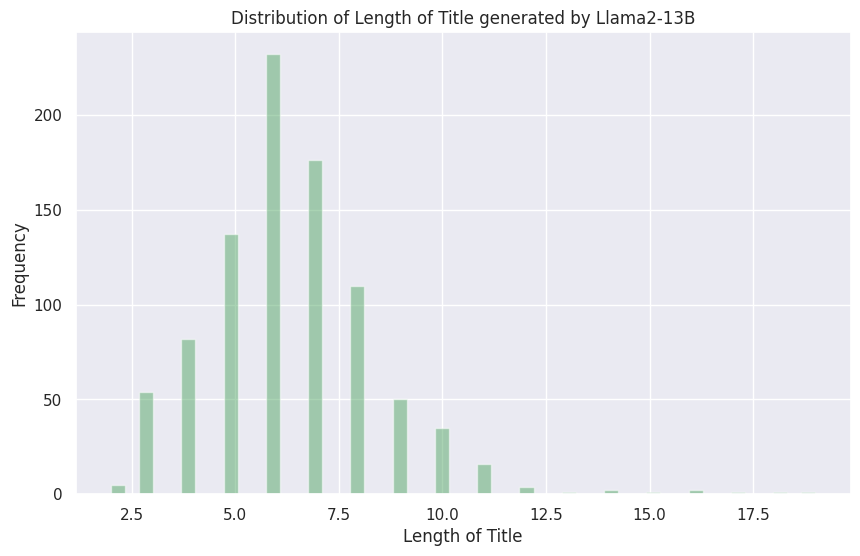

In [131]:
plt.figure(figsize=(10,6))
plt.hist(data.loc[data["Len_llama_title"]<20, 'Len_llama_title'], bins=50, alpha=0.5, color='g')
plt.title('Distribution of Length of Title generated by Llama2-13B')
plt.xlabel('Length of Title')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [150]:
generated_titles = data["Llama_title_13b"].to_list()
real_titles = data["Title"].to_list()
mean_levenshtein, mean_cosine, mean_bleu, mean_rouge1, mean_rougeL = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein:.2f}")
print(f"Mean Cosine Similarity {mean_cosine:.2f}")
print(f"Mean BLEU Score {mean_bleu:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL:.2f}")

Mean Levenshtein Similarity 0.35
Mean Cosine Similarity 0.29
Mean BLEU Score 0.17
Mean ROUGE-1 Score 0.40
Mean ROUGE-L Score 0.36


In [193]:
# Liste des noms des métriques
metric_names = ['Mean Levenshtein', 'Mean Cosine', 'Mean BLEU', 'Mean ROUGE-1', 'Mean ROUGE-L']

# Créer un dictionnaire vide pour stocker les résultats
results_dict = {metric: [] for metric in metric_names}

# Ajouter les moyennes des métriques calculées dans le dictionnaire
results_dict['Mean Levenshtein'].append(round(mean_levenshtein,2))
results_dict['Mean Cosine'].append(round(mean_cosine,2))
results_dict['Mean BLEU'].append(round(mean_bleu,2))
results_dict['Mean ROUGE-1'].append(round(mean_rouge1,2))
results_dict['Mean ROUGE-L'].append(round(mean_rougeL,2))

# Créer un DataFrame à partir du dictionnaire
results_df = pd.DataFrame(results_dict, index=["Llama_13B"])


In [194]:
results_df

,Mean Levenshtein,Mean Cosine,Mean BLEU,Mean ROUGE-1,Mean ROUGE-L
Llama_13B,0.35,0.29,0.17,0.4,0.36


In [195]:
# data.to_csv("data_llama_generated.csv", index=False)
results_df.to_csv("results_df.csv")

# Mistral

In [120]:
def generate_title_do(text, llm_model="mistral"):
    llm = ChatOllama(model=llm_model,temperature=0, device="cuda")

    prompt = ChatPromptTemplate.from_template("""<s>[INST] You are a helpful assistant.\
    Your task is to generate a title based on the given text. Provide only one proposition. [/INST]{text}.</s>
    [INST] The title must be concise and capture the essence of the text.  \
    Make sure the answer contains only the title in this format 'title'.[/INST]""")
    chain = (prompt | llm | StrOutputParser())
    return chain.invoke({text})

In [121]:
%%time
data['Mistral_title']= data['Text'].apply(generate_title_do)

CPU times: user 5.39 s, sys: 240 ms, total: 5.63 s
Wall time: 27min 48s


In [126]:
data["Len_mistral_title"]= data["Mistral_title"].apply(count_word_text)

In [127]:
data.Len_mistral_title.describe()

count    923.000000
mean      14.538462
std        8.776904
min        3.000000
25%       10.000000
50%       12.000000
75%       15.000000
max       91.000000
Name: Len_mistral_title, dtype: float64

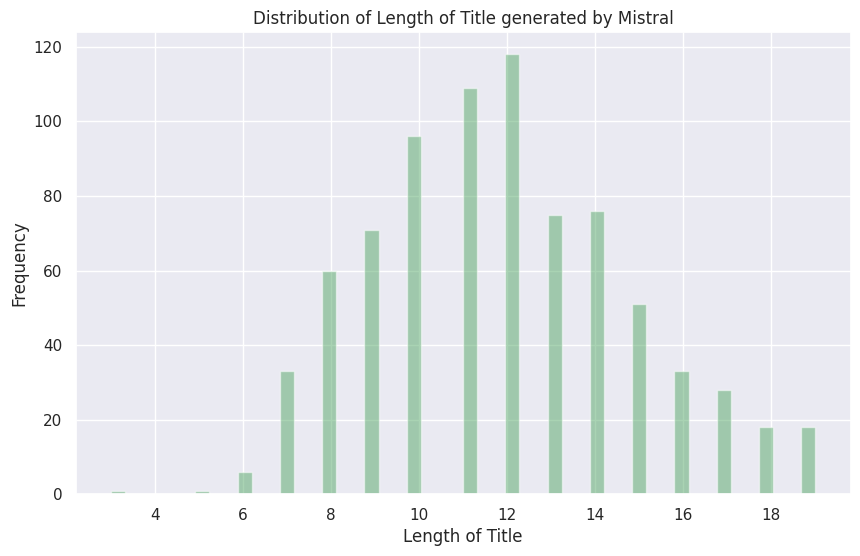

In [132]:
plt.figure(figsize=(10,6))
plt.hist(data.loc[data["Len_mistral_title"]<20, 'Len_mistral_title'], bins=50, alpha=0.5, color='g')
plt.title('Distribution of Length of Title generated by Mistral')
plt.xlabel('Length of Title')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [133]:
generated_titles = data["Mistral_title"].to_list()
real_titles = data["Title"].to_list()
mean_levenshtein_ms, mean_cosine_ms, mean_bleu_ms, mean_rouge1_ms, mean_rougeL_ms = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein_ms:.2f}")
print(f"Mean Cosine Similarity {mean_cosine_ms:.2f}")
print(f"Mean BLEU Score {mean_bleu_ms:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1_ms:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL_ms:.2f}")

Mean Levenshtein Similarity 0.29
Mean Cosine Similarity 0.24
Mean BLEU Score 0.16
Mean ROUGE-1 Score 0.33
Mean ROUGE-L Score 0.29


In [196]:
mistral_results = {
    "Mean Levenshtein": round(mean_levenshtein_ms,2),
    "Mean Cosine": round(mean_cosine_ms,2),
    "Mean BLEU": round(mean_bleu_ms,2),
    "Mean ROUGE-1": round(mean_rouge1_ms,2),
    "Mean ROUGE-L": round(mean_rougeL_ms,2)
}
mistral_df = pd.DataFrame(mistral_results, index=["Mistral_7B"])

# Ajouter les résultats de Mistral au DataFrame existant
results_df = pd.concat([results_df, mistral_df])

In [197]:
results_df

,Mean Levenshtein,Mean Cosine,Mean BLEU,Mean ROUGE-1,Mean ROUGE-L
Llama_13B,0.35,0.29,0.17,0.40,0.36
Mistral_7B,0.29,0.24,0.16,0.33,0.29


In [198]:
results_df.to_csv("results_df.csv")

In [50]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

## StableLM 2 Zephyr 1.6B

In [14]:
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# !pip install -U datasets flash-attn tiktoken transformers accelerate
!pip install flash-attn

In [ ]:
!pip install -qqq torch==2.1.0 --progress-bar off
!pip install -qqq transformers==4.37.0 --progress-bar off
!pip install -qqq tiktoken==0.5.1 --progress-bar off
!pip install -qqq accelerate==0.26.1 --progress-bar off
!pip install -qqq flash-attn==2.4.2 --progress-bar off

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

modelpath="stabilityai/stablelm-2-zephyr-1_6b"

tokenizer = AutoTokenizer.from_pretrained(
    modelpath,
    trust_remote_code=True,      # needed for Stable LM 2 based models
    use_fast=False,
) 

In [9]:
modelpath = "stabilityai/stablelm-2-zephyr-1_6b"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    attn_implementation="flash_attention_2",
    trust_remote_code=True,       # needed for Stable LM 2 based models
)

In [10]:
import time

### Evaluation de performances: 
#### 1. BLEU (Bilingual Evaluation Understudy) 

#### 2. ROUGE (Recall-Oriented Understudy for Gisting Evaluation) 

### Performances - StableLM 2 Zephyr 1.6B

In [22]:
def clean_generated_title(title):
    title = re.sub(r'^Title:\s*', '', title)
    cleaned_title = re.sub(r'^\"|\"$', '', title)
    return cleaned_title

In [31]:
from itertools import product

In [20]:
def get_stable_title(texte, gen_config):
    question = f"Generate an appropriate title to the following text in a maximum of 10 words. Do not provide explanations or justifications. \
    Make sure the answer contains only the title in this format 'title' \
    {texte}"
    messages = [{"role": "user", "content": question}]
    
    # Encoder le texte en utilisant le tokenizer
    input_tokens = tokenizer.apply_chat_template(messages, return_tensors="pt", add_generation_prompt=True).to("cuda")
    
    # Génère les titres en utilisant le modèle
    with torch.no_grad():
        output_tokens = model.generate(
            input_tokens, 
            **gen_config,
            pad_token_id=tokenizer.eos_token_id,  # Définition du token de padding sur eos_token_id
        )
    
    # Décoder les titres générés
    output_tokens = output_tokens[0][len(input_tokens[0]):]
    output = tokenizer.decode(output_tokens, skip_special_tokens=True)

    return output

In [21]:
def generate_title(text):
    return get_stable_title(text, gen_config)

In [162]:
gen_config = {
    "temperature": 0.7,
    "top_p": 0.5,
    "repetition_penalty": 0.5,
    "top_k": 20,
    "do_sample": True,
    "max_new_tokens": 50,
    }

In [165]:
%%time
# Appliquer la fonction à l'ensemble des données séléctionnées
data['StableLM_title'] = data['Text'].apply(generate_title)

CPU times: user 7min 21s, sys: 0 ns, total: 7min 21s
Wall time: 7min 21s


In [199]:
generated_titles = data["StableLM_title"].to_list()
real_titles = data["Title"].to_list()
mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
print(f"Mean BLEU Score {mean_bleu_st:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")

Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.29
Mean BLEU Score 0.22
Mean ROUGE-1 Score 0.38
Mean ROUGE-L Score 0.33


In [200]:
stable_results = {
    "Mean Levenshtein": round(mean_levenshtein_st,2),
    "Mean Cosine": round(mean_cosine_st,2),
    "Mean BLEU": round(mean_bleu_st,2),
    "Mean ROUGE-1": round(mean_rouge1_st,2),
    "Mean ROUGE-L": round(mean_rougeL_st,2)
}
stable_df = pd.DataFrame(stable_results, index=["StableLM_1.6B"])

# Ajouter les résultats de Mistral au DataFrame existant
results_df = pd.concat([results_df, stable_df])

In [201]:
results_df

,Mean Levenshtein,Mean Cosine,Mean BLEU,Mean ROUGE-1,Mean ROUGE-L
Llama_13B,0.35,0.29,0.17,0.40,0.36
Mistral_7B,0.29,0.24,0.16,0.33,0.29
StableLM_1.6B,0.33,0.29,0.22,0.38,0.33


In [207]:
results_df.to_csv("results_df.csv")
data.to_csv("data_generated_title.csv", index=False)

#### Recherche de meilleurs paramètres : StableLM 2 zephyr 1.6B

In [14]:
%%time
gen_config = {
    "temperature": 0.1, 
    "top_p": 1.0, 
    "repetition_penalty": 1.0, 
    "top_k": 20,  
    "do_sample": True,  
    "max_new_tokens": 40, 
}
data['StableLM_title'] = data['Text'].apply(generate_title)

generated_titles = data["StableLM_title"].to_list()
real_titles = data["Title"].to_list()
mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
print(f"Mean BLEU Score {mean_bleu_st:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")

Mean Levenshtein Similarity 0.32
Mean Cosine Similarity 0.26
Mean BLEU Score 0.17
Mean ROUGE-1 Score 0.37
Mean ROUGE-L Score 0.33
CPU times: user 7min 57s, sys: 248 ms, total: 7min 57s
Wall time: 7min 56s


In [23]:
data["StableLM_title"] = data["StableLM_title"].apply(clean_generated_title)
generated_titles = data["StableLM_title"].to_list()
real_titles = data["Title"].to_list()
mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
print(f"Mean BLEU Score {mean_bleu_st:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")

Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.26
Mean BLEU Score 0.20
Mean ROUGE-1 Score 0.38
Mean ROUGE-L Score 0.33


In [24]:
%%time
gen_config = {
    "temperature": 0.1, 
    "top_p": 0.7, 
    "repetition_penalty": 0.7, 
    "top_k": 20,  
    "do_sample": True,  
    "max_new_tokens": 40, 
}
data['StableLM_title'] = data['Text'].apply(generate_title)

generated_titles = data["StableLM_title"].to_list()
real_titles = data["Title"].to_list()
mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
print(f"Mean BLEU Score {mean_bleu_st:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")

Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.29
Mean BLEU Score 0.22
Mean ROUGE-1 Score 0.38
Mean ROUGE-L Score 0.33
CPU times: user 7min 13s, sys: 105 ms, total: 7min 13s
Wall time: 7min 13s


In [35]:
%%time
gen_config = {
    "temperature": 0.1, 
    "top_p": 0.7, 
    "repetition_penalty": 0.7, 
    "top_k": 10,  
    "do_sample": True,  
    "max_new_tokens": 40, 
}
data['StableLM_title'] = data['Text'].apply(generate_title)

generated_titles = data["StableLM_title"].to_list()
real_titles = data["Title"].to_list()
mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
print(f"Mean BLEU Score {mean_bleu_st:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")

Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.30
Mean BLEU Score 0.23
Mean ROUGE-1 Score 0.39
Mean ROUGE-L Score 0.33
CPU times: user 7min 30s, sys: 395 ms, total: 7min 30s
Wall time: 7min 29s


In [40]:
%%time
gen_config = {
    "temperature": 0.1, 
    "top_p": 0.7, 
    "repetition_penalty": 0.7, 
    "top_k": 8,  
    "do_sample": True,  
    "max_new_tokens": 30, 
}
data['StableLM_title'] = data['Text'].apply(generate_title)

generated_titles = data["StableLM_title"].to_list()
real_titles = data["Title"].to_list()
mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
print(f"Mean BLEU Score {mean_bleu_st:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")

Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.30
Mean BLEU Score 0.23
Mean ROUGE-1 Score 0.39
Mean ROUGE-L Score 0.33
CPU times: user 6min 56s, sys: 163 ms, total: 6min 56s
Wall time: 6min 56s


In [47]:
# temperatures = [0.1] 
top_ps = [0.5, 0.75, 1.0]        
# top_ks = [8]           
# do_samples = [True]       
repetition_penalties = [0.5, 0.75, 1.0]  
# "max_new_tokens": 30

In [51]:
from itertools import product

In [53]:
for i in product( top_ps, repetition_penalties):
    print(i)

(0.5, 0.5)
(0.5, 0.75)
(0.5, 1.0)
(0.75, 0.5)
(0.75, 0.75)
(0.75, 1.0)
(1.0, 0.5)
(1.0, 0.75)
(1.0, 1.0)


In [54]:
%%time
# Générer une grille pour tester les combinaison des paramètres top_p et repetition_penalty
for top_p, repetition_penalty in product( top_ps, repetition_penalties):
    # Configuration de génération avec les valeurs actuelles des paramètres
    gen_config = {
        "temperature": 0.1,
        "top_p": top_p,
        "top_k": 8,
        "do_sample": True,
        "repetition_penalty": repetition_penalty,
        "max_new_tokens": 30,  
    }
    print(f"top_p={top_p} - repetition_penalty={repetition_penalty}")
    print("-------------------------------------------")
    # Générer des titres avec la configuration actuelle
    data['StableLM_title'] = data['Text'].apply(generate_title)
    generated_titles = data["StableLM_title"].to_list()
    real_titles = data["Title"].to_list()
    mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

    print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
    print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
    print(f"Mean BLEU Score {mean_bleu_st:.2f}")
    print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
    print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")
    print("\n-----------------------------------------\n")
        

top_p=0.5 - repetition_penalty=0.5
-------------------------------------------
Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.29
Mean BLEU Score 0.23
Mean ROUGE-1 Score 0.38
Mean ROUGE-L Score 0.33

-----------------------------------------

top_p=0.5 - repetition_penalty=0.75
-------------------------------------------
Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.30
Mean BLEU Score 0.23
Mean ROUGE-1 Score 0.39
Mean ROUGE-L Score 0.34

-----------------------------------------

top_p=0.5 - repetition_penalty=1.0
-------------------------------------------
Mean Levenshtein Similarity 0.32
Mean Cosine Similarity 0.26
Mean BLEU Score 0.17
Mean ROUGE-1 Score 0.37
Mean ROUGE-L Score 0.33

-----------------------------------------

top_p=0.75 - repetition_penalty=0.5
-------------------------------------------
Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.30
Mean BLEU Score 0.23
Mean ROUGE-1 Score 0.39
Mean ROUGE-L Score 0.33

-----------------------------

In [56]:
# temperatures = [0.1] 
top_ps = [0.8, 0.9]        
# top_ks = [8]           
# do_samples = [True]       
repetition_penalties = [0.8, 0.9]  
# "max_new_tokens": 30

In [57]:
%%time
# Générer une grille pour tester les combinaison des paramètres top_p et repetition_penalty
for top_p, repetition_penalty in product( top_ps, repetition_penalties):
    # Configuration de génération avec les valeurs actuelles des paramètres
    gen_config = {
        "temperature": 0.1,
        "top_p": top_p,
        "top_k": 8,
        "do_sample": True,
        "repetition_penalty": repetition_penalty,
        "max_new_tokens": 30,  
    }
    print(f"top_p={top_p} - repetition_penalty={repetition_penalty}")
    print("-------------------------------------------")
    # Générer des titres avec la configuration actuelle
    data['StableLM_title'] = data['Text'].apply(generate_title)
    generated_titles = data["StableLM_title"].to_list()
    real_titles = data["Title"].to_list()
    mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

    print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
    print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
    print(f"Mean BLEU Score {mean_bleu_st:.2f}")
    print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
    print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")
    print("\n-----------------------------------------\n")
        

top_p=0.8 - repetition_penalty=0.8
-------------------------------------------
Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.29
Mean BLEU Score 0.22
Mean ROUGE-1 Score 0.39
Mean ROUGE-L Score 0.34

-----------------------------------------

top_p=0.8 - repetition_penalty=0.9
-------------------------------------------
Mean Levenshtein Similarity 0.32
Mean Cosine Similarity 0.27
Mean BLEU Score 0.20
Mean ROUGE-1 Score 0.38
Mean ROUGE-L Score 0.33

-----------------------------------------

top_p=0.9 - repetition_penalty=0.8
-------------------------------------------
Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.30
Mean BLEU Score 0.22
Mean ROUGE-1 Score 0.39
Mean ROUGE-L Score 0.34

-----------------------------------------

top_p=0.9 - repetition_penalty=0.9
-------------------------------------------
Mean Levenshtein Similarity 0.32
Mean Cosine Similarity 0.28
Mean BLEU Score 0.19
Mean ROUGE-1 Score 0.38
Mean ROUGE-L Score 0.33

-------------------------------

In [60]:
df = pd.read_csv("data_generated_title.csv")

In [62]:
%%time
gen_config = {
    "temperature": 0.1, 
    "top_p": 1, 
    "repetition_penalty": 0.75, 
    "top_k": 8,  
    "do_sample": True,  
    "max_new_tokens": 30, 
}
df['StableLM_title'] = df['Text'].apply(generate_title)

generated_titles = df["StableLM_title"].to_list()
real_titles = df["Title"].to_list()
mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
print(f"Mean BLEU Score {mean_bleu_st:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")

Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.30
Mean BLEU Score 0.23
Mean ROUGE-1 Score 0.39
Mean ROUGE-L Score 0.34


In [77]:
results_df = pd.read_csv("results_df.csv", index_col=["Unnamed: 0"])
results_df = results_df.drop(index="StableLM_1.6B")

In [78]:
results_df

,Mean Levenshtein,Mean Cosine,Mean BLEU,Mean ROUGE-1,Mean ROUGE-L
Llama_13B,0.35,0.29,0.17,0.40,0.36
Mistral_7B,0.29,0.24,0.16,0.33,0.29


In [79]:
stable_results = {
    "Mean Levenshtein": round(mean_levenshtein_st,2),
    "Mean Cosine": round(mean_cosine_st,2),
    "Mean BLEU": round(mean_bleu_st,2),
    "Mean ROUGE-1": round(mean_rouge1_st,2),
    "Mean ROUGE-L": round(mean_rougeL_st,2)
}
stable_df = pd.DataFrame(stable_results, index=["StableLM_1.6B"])

# Ajouter les résultats de Mistral au DataFrame existant
results_df = pd.concat([results_df, stable_df])

In [80]:
results_df

,Mean Levenshtein,Mean Cosine,Mean BLEU,Mean ROUGE-1,Mean ROUGE-L
Llama_13B,0.35,0.29,0.17,0.40,0.36
Mistral_7B,0.29,0.24,0.16,0.33,0.29
StableLM_1.6B,0.33,0.30,0.23,0.39,0.34


In [81]:
df["Len_stable_title"] = df["StableLM_title"].apply(count_word_text)

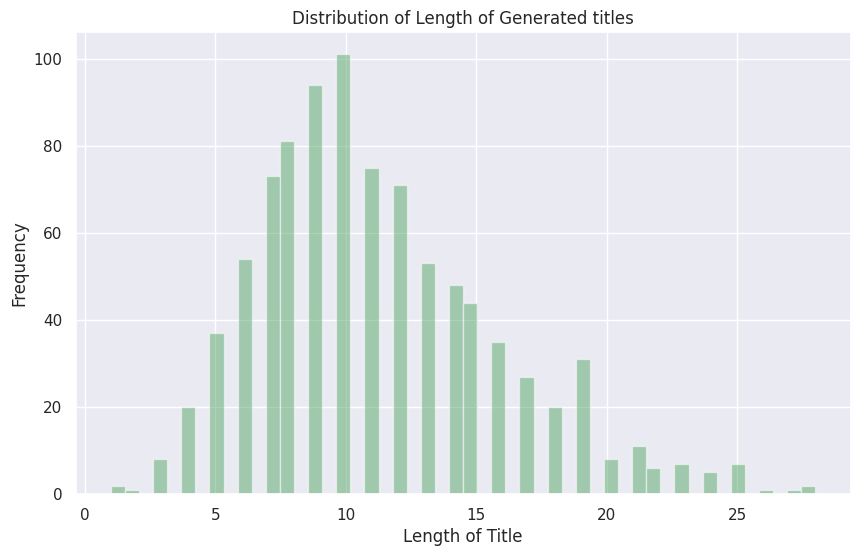

In [82]:
plt.figure(figsize=(10,6))
plt.hist(df["Len_stable_title"], bins=50, alpha=0.5, color='g')
plt.title('Distribution of Length of Generated titles')
plt.xlabel('Length of Title')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [83]:
results_df.to_csv("results_df.csv")
df.to_csv("data_generated_title.csv", index=False)

In [ ]:
!pip install quanto==0.0.11

In [9]:
!pip install torch==2.1.1

  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl.metadata (1.8 kB)
  Using cached triton-2.1.0-0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 12.5 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl (209.8 MB)
Using cached triton-2.1.0-0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (89.2 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully uninstalled nvidia-nccl-cu12-2.20.5
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0
ERROR: pip's dependency resolver 

In [7]:
from quanto import quantize, freeze
from helper import compute_module_sizes
import time

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
modelpath="stabilityai/stablelm-2-zephyr-1_6b"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    attn_implementation="flash_attention_2",
    trust_remote_code=True,       # needed for Stable LM 2 based models
)

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    modelpath,
    trust_remote_code=True,      # needed for Stable LM 2 based models
    use_fast=False,
) 

In [10]:
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")

The model size is 3.29532288 GB


In [11]:
model

StableLmForCausalLM(
  (model): StableLmModel(
    (embed_tokens): Embedding(100352, 2048)
    (layers): ModuleList(
      (0-23): 24 x StableLmDecoderLayer(
        (self_attn): StableLmFlashAttention2(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (attention_dropout): Dropout(p=0.0, inplace=False)
          (rotary_emb): StableLmRotaryEmbedding()
        )
        (mlp): StableLmMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affin

In [12]:
quantize(model, weights=torch.int8, activations=None)

In [14]:
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")

The model size is 3.295324232 GB


In [15]:
freeze(model)

In [16]:
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")

The model size is 1.8579108560000002 GB


In [18]:
gen_config = {
    "temperature": 0.1, 
    "top_p": 1, 
    "repetition_penalty": 0.75, 
    "top_k": 8,  
    "do_sample": True,  
    "max_new_tokens": 30, 
}

In [21]:
# Avant quantisation
%%time
get_stable_title(data.Text[0], gen_config)

CPU times: user 2.68 s, sys: 501 ms, total: 3.18 s
Wall time: 3.2 s


"'PyTorch Geometric Graph Neural Network Tutorial'"

In [22]:
# Après quantisation
%%time
get_stable_title(data.Text[0], gen_config)

CPU times: user 1.35 s, sys: 22.6 ms, total: 1.37 s
Wall time: 1.37 s


"'PyTorch Geometric GNN Tutorial: Building and Solving Graph Neural Network Problems'"

In [23]:
%%time

data['StableLM_title'] = data['Text'].apply(generate_title)

generated_titles = data["StableLM_title"].to_list()
real_titles = data["Title"].to_list()
mean_levenshtein_st, mean_cosine_st, mean_bleu_st, mean_rouge1_st, mean_rougeL_st = get_performances(generated_titles, real_titles)

print(f"Mean Levenshtein Similarity {mean_levenshtein_st:.2f}")
print(f"Mean Cosine Similarity {mean_cosine_st:.2f}")
print(f"Mean BLEU Score {mean_bleu_st:.2f}")
print(f"Mean ROUGE-1 Score {mean_rouge1_st:.2f}")
print(f"Mean ROUGE-L Score {mean_rougeL_st:.2f}")

Mean Levenshtein Similarity 0.33
Mean Cosine Similarity 0.30
Mean BLEU Score 0.23
Mean ROUGE-1 Score 0.39
Mean ROUGE-L Score 0.34
CPU times: user 18min 8s, sys: 70.2 ms, total: 18min 8s
Wall time: 18min 8s


### Test sur CPU

In [3]:
from quanto import quantize, freeze
from helper import compute_module_sizes
import time
import torch

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
modelpath="stabilityai/stablelm-2-zephyr-1_6b"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    torch_dtype=torch.bfloat16,
    device_map="cpu",
    # attn_implementation="flash_attention_2",
    trust_remote_code=True,       # needed for Stable LM 2 based models
)

/home/fayz/Bureau/Mona/openclassrooms/Projets/Projet_7/venv7/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

/home/fayz/Bureau/Mona/openclassrooms/Projets/Projet_7/venv7/lib/python3.8/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/fayz/Bureau/Mona/openclassrooms/Projets/Projet_7/venv7/lib/python3.8/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
/home/fayz/Bureau/Mona/openclassrooms/Projets/Projet_7/venv7/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be remo

model.safetensors:   0%|          | 0.00/3.29G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    modelpath,
    trust_remote_code=True,      # needed for Stable LM 2 based models
    use_fast=False,
) 

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/784 [00:00<?, ?B/s]

In [6]:
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")

The model size is 3.29532288 GB


In [7]:
model

StableLmForCausalLM(
  (model): StableLmModel(
    (embed_tokens): Embedding(100352, 2048)
    (layers): ModuleList(
      (0-23): 24 x StableLmDecoderLayer(
        (self_attn): StableLmSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (attention_dropout): Dropout(p=0.0, inplace=False)
          (rotary_emb): StableLmRotaryEmbedding()
        )
        (mlp): StableLmMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=

In [8]:
quantize(model, weights=torch.int8, activations=None)

In [9]:
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")

The model size is 3.295324232 GB


In [10]:
freeze(model)

In [11]:
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")

The model size is 1.8579108560000002 GB


In [12]:
gen_config = {
    "temperature": 0.1, 
    "top_p": 1, 
    "repetition_penalty": 0.75, 
    "top_k": 8,  
    "do_sample": True,  
    "max_new_tokens": 30, 
}

In [18]:
texte = data.Text[0]

In [19]:
question = f"Generate an appropriate title to the following text in a maximum of 10 words. Do not provide explanations or justifications. \
Make sure the answer contains only the title in this format 'title' \
{texte}"
messages = [{"role": "user", "content": question}]

# Encoder le texte en utilisant le tokenizer
input_tokens = tokenizer.apply_chat_template(messages, return_tensors="pt", add_generation_prompt=True).to("cpu")

# Génère les titres en utilisant le modèle
with torch.no_grad():
    output_tokens = model.generate(
        input_tokens, 
        **gen_config,
        pad_token_id=tokenizer.eos_token_id,  # Définition du token de padding sur eos_token_id
    )

# Décoder les titres générés
output_tokens = output_tokens[0][len(input_tokens[0]):]
output = tokenizer.decode(output_tokens, skip_special_tokens=True)



In [20]:
output

"'PyTorch Geometric GNN Tutorial: Building and Solving Graph Neural Network Problems'"

In [21]:
data.loc[data["Len_text"]<150]

,Title,Text,text_char,Len_text,Len_title,Text_clean,Text_tokens,Text_tokens_clean,Title_clean
0,Hands-on Graph Neural Networks with PyTorch & ...,"In my last article, I introduced the concept o...",829,139,9,"in my last article, i introduced the concept o...","['in', 'my', 'last', 'article', 'i', 'introduc...","['last', 'article', 'introduced', 'concept', '...","['hands', 'graph', 'neural', 'networks', 'pyto..."
11,20 must-know Data Science Interview Questions,20 must-know Data Science Interview Questions\...,410,69,6,20 must-know data science interview questions ...,"['20', 'must', 'know', 'data', 'science', 'int...","['must', 'know', 'data', 'science', 'interview...","['must', 'know', 'data', 'science', 'interview..."
18,"Implementation of RNN, LSTM, and GRU",Recurrent Neural Network\n\nThe Recurrent neur...,922,142,6,recurrent neural network the recurrent neural...,"['recurrent', 'neural', 'network', 'the', 'rec...","['recurrent', 'neural', 'network', 'recurrent'...","['implementation', 'rnn', 'lstm', 'gru']"
23,Speeding up data wrangling with dtplyr,Generating the dataset\n\nWe generate an artif...,561,99,6,generating the dataset we generate an artific...,"['generating', 'the', 'dataset', 'we', 'genera...","['generating', 'dataset', 'generate', 'artific...","['speeding', 'data', 'wrangling', 'dtplyr']"
26,Sentiment Analysis: a practical benchmark,Sentiment Analysis: a practical benchmark\n\nW...,916,138,5,sentiment analysis: a practical benchmark wit...,"['sentiment', 'analysis', 'a', 'practical', 'b...","['sentiment', 'analysis', 'practical', 'benchm...","['sentiment', 'analysis', 'practical', 'benchm..."
29,SQL Subqueries,SQL Subqueries\n\nPhoto by Henri L. on Unsplas...,806,141,2,sql subqueries photo by henri l. on unsplash ...,"['sql', 'subqueries', 'photo', 'by', 'henri', ...","['sql', 'subqueries', 'photo', 'henri', 'unspl...","['sql', 'subqueries']"
49,Review: DeepPose — Cascade of CNN (Human Pose ...,Review: DeepPose — Cascade of CNN (Human Pose ...,375,61,9,review: deeppose — cascade of cnn (human pose ...,"['review', 'deeppose', 'cascade', 'of', 'cnn',...","['review', 'deeppose', 'cascade', 'cnn', 'huma...","['review', 'deeppose', 'cascade', 'cnn', 'huma..."
57,"What Is Neuralink: A Look At What It Is, What ...",When I first took science class in elementary ...,794,142,19,when i first took science class in elementary ...,"['when', 'i', 'first', 'took', 'science', 'cla...","['first', 'took', 'science', 'class', 'element...","['neuralink', 'look', 'wants', 'could', 'become']"
61,The Easiest Python Numpy Tutorial Ever,The Easiest Python Numpy Tutorial Ever\n\nPie\...,825,144,6,the easiest python numpy tutorial ever pie w...,"['the', 'easiest', 'python', 'numpy', 'tutoria...","['easiest', 'python', 'numpy', 'tutorial', 'ev...","['easiest', 'python', 'numpy', 'tutorial', 'ev..."
70,How 90% of Drivers Can be “Above Average” or W...,How 90% of Drivers Can be “Above Average” or W...,842,138,18,how 90% of drivers can be “above average” or w...,"['how', '90', 'of', 'drivers', 'can', 'be', 'a...","['drivers', 'average', 'need', 'careful', 'usi...","['drivers', 'average', 'need', 'careful', 'usi..."


In [22]:
data.Text[11]

'20 must-know Data Science Interview Questions\n\nA non-exhaustive(duh) list of some of the good data science questions I have come across. I hope this list is of use to someone wanting to brush up some basic concepts. Kudos to the authors of all the amazing posts mentioned here.\n\nQ. Define mean, mode, median. Explain these concepts to a layman. When is either preferred over the other. Give practical examples.'